# Notes

In [659]:
# 1. Check iter_cb() function of lmfit - possibility to run anything at each iteration of fitting. 
# Good to input progressbar or some fancy stuff

# 2. ! Now I am feeding PC activity from the average of whole population. That means I am not capturing trends from
# depressors and sensitisors. Maybe, we need to add sub-populations activities to the model?

# 3. Look for different activation functions (examples from neuron networks). Check papers.

# Imports

In [660]:
%%time
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from lmfit import minimize, Parameter, Parameters, report_fit
from IPython import display
#from progressbar import progressbar
#from numba import jit


CPU times: total: 0 ns
Wall time: 0 ns


# Model diagram

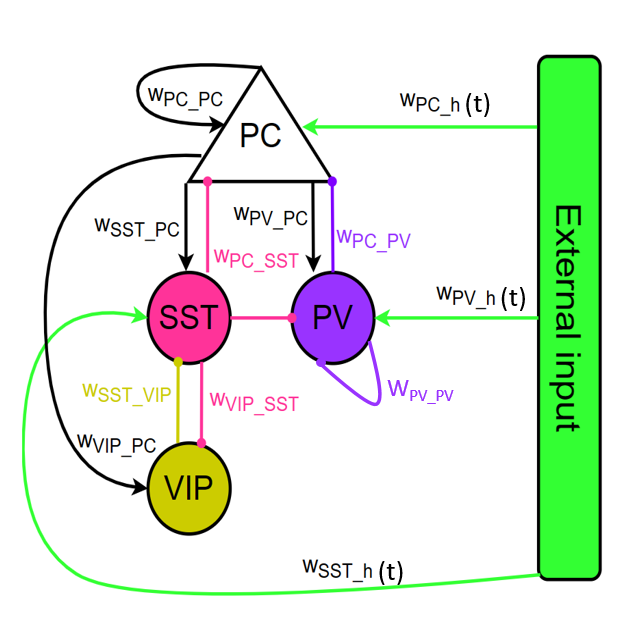

In [661]:
display.Image(r'Model_diagram.png')

In [662]:
# count = 0

# Functions

In [663]:
def exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 1, amp = 1):
    if (t < stim) or (t > stim + inter):
        h = base
    else:
        h = amp*np.exp(-(t-stim)*decay)
    return h

In [664]:
def invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 1, amp = 1, delta = 0):
    if (t < stim) or (t > stim + inter):
        h = base
    else:
        h = (amp)*(t-stim+delta)**(-decay)
    return h

In [665]:
def Step(t, stim = 5, inter = 10, amp = 1.0, base = 0, k = 1, delay = 0, decay_f = 0):
    """
    Step-like output.
    """
    
    if (t < stim + delay) or (t > stim + inter):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    # elif (t > stim + inter):
    #     h = amp*np.exp(-(t - stim - inter)*decay_f) + base
        
    else:
        h = amp*(t - stim - delay)*k*0.164745 + amp
    
    return h

In [666]:
def Step_1(t, stim = 5, k = 0, inter = 10, amp = 1.0, base = 1):
    """
    Step-like output.
    """
    
    if (t < stim) or (t > stim + inter):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    else:
        h = amp*(t - stim)*k*0.164745 + amp
    
    return h

In [667]:
def Sigm(t, stim = 5, inter = 10, ampl = 1.0, base = 0, rate = 1, delay = 0, decay_s = 1, dt = 0.164745):
    """
    Step-like output.
    """
    
    if (t < stim):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    elif (t > stim + inter + dt):
        h = (base + (ampl/(1 + np.exp((delay-inter - dt)/rate))))*np.exp(-(t - stim - inter - dt)*decay_s) + base
    
    else:
        h = base + (ampl/(1 + np.exp((stim + delay - t)/rate))) #Actualy rate here is time constant, where 1/rate is actual rate
        
    
    return h

In [668]:
def expon(t, stim = 5, inter = 10, ampl = 1.5, base = 0, decay = 1, delay = 0, b = 0, decay_ff = 0):
    if (t < stim + delay):
        h = b
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    elif (t > stim + inter):
        h = (b + base + ampl*np.exp(-(inter-delay)*decay))*np.exp(-(t - stim - inter)*decay_ff)
    else:
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)
        
    return h

In [669]:
 def f_e_avg(t, data):
     """
    
     """    
    
     return np.interp(t, t_exp, data)

In [670]:
# def f_p(t, data):
#     """
    
#     """    
    
#     return np.interp(t, t_exp, data)

In [671]:
# def f_s(t):
#     """
    
#     """
    
#     return np.interp(t, t_exp, data_sst) 

In [672]:
# def f_v_f(t, data):
#     """
    
#     """    
    
#     return np.interp(t, t_exp, data)

In [673]:
# @jit(parallel=True, fastmath=True)
def model_step(t,
               y,
               w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18,
               tau_0, tau_1, tau_2, tau_3,
               threshold,
               power,
               q,
               i_0, i_1, i_2, i_3,
               r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff
               ):
    """
    Builds differential equation model of visual cortex network with step input h
    """
    
            
    f_e, f_p, f_s, f_v, f_e_o, f_p_o, f_s_o, f_v_o = y
    
    ff_e = (min(max((i_0 + w_0 * f_e + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p - w_4 * f_s), threshold), 25))
    #ff_e_d = (min(max((i_d_0 + w_d_0 * f_e + w_d_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1) + w_d_2 *0* Sigm(t, rate = r_1, delay = delay_2) + w_d_3 * Step(t, k = 0, delay = delay_3) - w_d_4 * f_p - w_d_5 * f_s), threshold), 25))
    ff_p = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p - w_9 * f_s), threshold), 25))
    ff_s = (min(max((i_2 + w_10 * f_e + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v), threshold), 25))
    ff_v = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e - w_14 * f_s +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
        
    ff_e_o = (min(max((i_0 + w_0 * f_e_o + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p_o - w_4 * f_s_o), threshold), 25))
    ff_p_o = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e_o + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p_o - w_9 * f_s_o), threshold), 25)) #*invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1, delta = 1) *Step_1(t, k=-0.2) Step_1(t, amp = 1.0, k=-0.13) exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.01, amp = 1) *invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1)
    ff_s_o = (min(max((i_2 + w_10 * f_e_o + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v_o), threshold), 25))
    ff_v_o = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e_o - w_14 * f_s_o +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
    
        
    df_edt = ((q * ff_e ** power) - f_e) / tau_0
    #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
    df_pdt = ((q * ff_p ** power) - f_p) / tau_1
    df_sdt = ((q * ff_s ** power) - f_s) / tau_2
    df_vdt = ((q * ff_v ** power) - f_v) / tau_3
    
    if (t>=5) and (t<=15):
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
        df_p_odt = ((q * (ff_p_o) ** power) - f_p_o) / tau_1
        df_s_odt = ((q * (ff_s_o*1.6) ** power) - f_s_o) / tau_2
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
        
    else:
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
        df_p_odt = ((q * (ff_p_o) ** power) - f_p_o) / tau_1
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
    
#     dGdt = (- G + g * D * S) / tau_e
#     dDdt = (1 - D) / tau_d + D * np.log(d) * w_13 * Step(t, amp = 1.5, base = 0.0)
#     dSdt = (1 - S) / tau_s + S * np.log(s) *  w_13 * Step(t, amp = 1.5, base = 0.0)

    dydt = [df_edt, df_pdt, df_sdt, df_vdt, df_e_odt, df_p_odt, df_s_odt, df_v_odt]
    
    return dydt

In [674]:
names = ['w_PC_PC', # w_0
         'w_EX_PC', # w_1
         'w_SI_PC', # w_2
         'w_PV_PC', # w_3
         'w_SS_PC', # w_4
         'w_PC_PV', # w_5
         'w_EX_PV', # w_6
         'w_SI_PV', # w_7
         'w_PV_PV', # w_8
         'w_SS_PV', # w_9
         'w_PC_SS', # w_10
         'w_ST_SS', # w_11
         'w_VI_SS', # w_12
         'w_PC_VI', # w_13
         'w_SS_VI', # w_14
         'w_SI_VI', # w_15
         'w_ST_PC', # w_16
         'w_PC_PC', # w_17
         'w_PC_PC', # w_18
         'w_PC_PC', # w_19
         'w_PC_PC'] # w_20

In [675]:
#@njit(parallel=True, fastmath=True)
def exp_time(start, step, count, endpoint=False):
    """
    Returns NumPy array of experimental timepoints of data
    """
    stop = start+(step*count)
    return np.linspace(start, stop, count, endpoint=endpoint)

In [676]:
#@jit(parallel=True, fastmath=True)
def odesol_step(tt, init, params): 
    """
    Solves ODEs system for step input
    """
    y_init = init
    w_0 = params['w_0'].value
    w_1 = params['w_1'].value
    w_2 = params['w_2'].value
    w_3 = params['w_3'].value
    w_4 = params['w_4'].value
    w_5 = params['w_5'].value
    w_6 = params['w_6'].value
    w_7 = params['w_7'].value
    w_8 = params['w_8'].value
    w_9 = params['w_9'].value
    w_10 = params['w_10'].value
    w_11 = params['w_11'].value
    w_12 = params['w_12'].value
    w_13 = params['w_13'].value
    w_14 = params['w_14'].value
    w_15 = params['w_15'].value
    w_16 = params['w_16'].value
    w_17 = params['w_17'].value
    w_18 = params['w_18'].value
    
    tau_0 = params['tau_0'].value
    tau_1 = params['tau_1'].value
    tau_2 = params['tau_2'].value
    tau_3 = params['tau_3'].value
    threshold = params['threshold'].value
    power = params['power'].value
    q = params['q'].value
    i_0 = params['i_0'].value
    i_1 = params['i_1'].value
    i_2 = params['i_2'].value
    i_3 = params['i_3'].value
    ampl_1 = params['ampl_1'].value
#     ampl_2 = params['ampl_2'].value
#     ampl_3 = params['ampl_3'].value
#     kl = params['kl'].value
#     kl_1 = params['kl_1'].value
#     kl_2 = params['kl_2'].value
#     s_1 = params['s_1'].value
#     s_2 = params['s_2'].value
    r_1 = params['r_1'].value
    delay_1 = params['delay_1'].value
    delay_2 = params['delay_2'].value
    delay_3 = params['delay_3'].value
    decay = params['decay'].value
    decay_s = params['decay_s'].value
    decay_f = params['decay_f'].value
    decay_ff = params['decay_ff'].value
    ampl = params['ampl'].value
    base = params['base'].value
    base_sigm = params['base_sigm'].value
   
    
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    
    return sol

In [677]:
def odesol_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff):
    
    y_init = init
    tt = t_exp
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    return sol

In [678]:
def simulate_step(tt, init, params):
    """
    Simulates model
    """
    
#     global count, max_nfev, data_pv
#     #f_e_ = []
#     f_pv_ = []
#     f_sst_ = []
#     f_vip_ = []
    
    sol = odesol_step(tt, init, params)
    
    #print('\r',' ',sol.message, 'count # ', count, '/', end='')
    #print(f'\r {sol.message} Count # {count}/{max_nfev}', end='')
    #print(count)
    #count += 1
    
#     for i in sol.t:
#         #f_e_.append(f_e_avg(i))
#         f_pv_.append(f_p(i, data_pv))
#         f_sst_.append(f_s(i))
#         f_vip_.append(f_v(i))
    
#     print(sol.t)
#     print(sol.y[0])
#     print(np.array(f_pv_))
#     print(np.array(f_sst_))
#     print(np.array(f_vip_))
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o'])
    
    return sim

In [679]:
def simulate_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                   tau_0, tau_1, tau_2, tau_3,
                   threshold,
                   power, 
                   q,
                   i_0, i_1, i_2, i_3,
                   r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff):
    """
    Simulates model
    """
    
#     global count, max_nfev, data_pv
#     #f_e_ = []
#     f_pv_ = []
#     f_sst_ = []
#     f_vip_ = []
    
    sol = odesol_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff)
    
    #print('\r',' ',sol.message, 'count # ', count, '/', end='')
    #print(f'\r {sol.message} Count # {count}/{max_nfev}', end='')
    #print(count)
    #count += 1
    
#     for i in sol.t:
#         #f_e_.append(f_e_avg(i))
#         f_pv_.append(f_p(i, data_pv))
#         f_sst_.append(f_s(i))
#         f_vip_.append(f_v(i))
    
#     print(sol.t)
#     print(sol.y[0])
#     print(np.array(f_pv_))
#     print(np.array(f_sst_))
#     print(np.array(f_vip_))
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o'])
    
    return sim

In [680]:
def residual_step(params, tt, init, data_pc, data_pv, data_sst, data_vip):
    """
    Difference between model and data for further minimization
    """
    global count, max_nfev
    
    weights_sst=np.float32(np.zeros_like(data_pc))
    weights_vip=np.float32(np.zeros_like(data_pc))
    weights_pv=np.float32(np.zeros_like(data_pc))
    weights_pc=np.float32(np.zeros_like(data_pc))
    
    weights_pv[0:24]=1.
    weights_pv[24:36]=0.05
    weights_pv[36:]=1. #:93
    
    #weights_1[85:]=1.
    #weights[50:80]=1.
    weights_sst[0:24]=1.
    weights_sst[24:30]=1.0
    weights_sst[30:]=1.0
    
    weights_vip[0:24]=1.
    weights_vip[24:30]=1.0
    weights_vip[30:]=1.0
    
    weights_pc[0:24]=1.
    weights_pc[24:30]=0.05
    weights_pc[30:38]=3.
    weights_pc[38:93]=1.
    weights_pc[93:107]=2.

    weights_pv = weights_pv * 3
    weights_sst = weights_sst * 3
    weights_pc = weights_pc * 3
    weights_vip = weights_vip * 3
    
    model = simulate_step(tt, init, params)
    pc_r = (np.float32(np.array(model['f_e'].values - data_pc))*weights_pc).ravel() #/pc_all_err_new
    pv_r = (np.float32(np.array(model['f_pv'].values - data_pv))*weights_pv).ravel() #/pv_err_new
    sst_r = (np.float32(np.array(model['f_sst'].values - data_sst))*weights_sst).ravel() # /sst_err_new
    vip_r = (np.float32(np.array(model['f_vip'].values - data_vip))*weights_vip).ravel() # /vip_err_new
    
    arr = np.concatenate((pc_r,pv_r,sst_r,vip_r), axis=0)
    
    display.clear_output(wait=True)
    plt.figure(figsize = (15,5))
    plt.plot(t_exp, data_pc, color='black', marker='o', label='f_pc(t)')
    plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
    plt.title('leastsq_PC')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.ylim(0, 2.0)
    plt.xticks(np.arange(0,21,1))
    plt.grid()
    text = str(count) + ' ' + '/' + ' ' + str(max_nfev) 
    
    bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)
    plt.text(20.6, 0.45, text, fontsize=12, bbox=bbox, horizontalalignment='right')
    count += 1
    
    plt.show()
    
    
    # plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
    # plt.plot(t_exp, curve, color = 'green', label='input')
    
    
    
    return arr

In [681]:
def residual_ad(params, tt, init, data_pc, data_pc_na):
    """
    Difference between model and data for further minimization
    """
    global count, max_nfev
    
    weights=np.float32(np.zeros_like(data_pc))
    weights_1=np.float32(np.zeros_like(data_pc))
    weights_2=np.float32(np.zeros_like(data_pc))
    weights_1[0:24]=1.
    weights_1[24:35]=0.05
    weights_1[35:91]=1.
    #weights_1[85:]=1.
    #weights[50:80]=1.
    weights[0:24]=1.
    weights[24:30]=0.05
    weights[30:91]=1.
    weights_2[0:24]=1.
    weights_2[24:36]=0.05
    weights_2[30:36]=3.
    weights_2[36:91]=1.
    
    model = simulate_step(tt, init, params)
    #pc_r = np.float32(np.array(model['f_e'].values - data_pc))*weights_2.ravel() #/np.array(pc_sen_err_new)
    pc_d_r = np.array(model['f_e_d'].values - data_pc_na)*weights_2.ravel()
    #pv_r = np.float32(np.array(model['f_pv'].values - data_pv))*weights_1.ravel()
    #sst_r = np.float32(np.array(model['f_sst'].values - data_sst))*weights.ravel()
    #vip_r = np.float32(np.array(model['f_vip'].values - data_vip))*weights.ravel()
    
    #arr = np.concatenate((pc_r,pv_r,sst_r,vip_r), axis=0)
    
    display.clear_output(wait=True)
    plt.figure(figsize = (15,5))
    plt.plot(t_exp, data_pc, color='black', marker='o', label='f_pc(t)')
    plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
    plt.title('leastsq_PC')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.ylim(0, 2.0)
    plt.xticks(np.arange(0,21,1))
    plt.grid()
    text = str(count) + ' ' + '/' + ' ' + str(max_nfev) 
    
    bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)
    plt.text(20.6, 0.45, text, fontsize=12, bbox=bbox, horizontalalignment='right')
    count += 1
    
    plt.show()
    
    
    # plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
    # plt.plot(t_exp, curve, color = 'green', label='input')
    
    
    
    return pc_d_r

In [682]:
def slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff):
    
    model_local = simulate_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff)
    
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    ax[0, 0].plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
    ax[0, 0].plot(t_exp, model_local['f_e'].values, color='blue', label='fit', linewidth=3)
    ax[0, 0].plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
    ax[0, 0].plot(t_exp, model_local['f_e_o'].values, color='red', label='fit', linewidth=3)
    
    ax[1, 0].plot(t_exp, data_pv, color='black', marker='o', label='f_pc(t)')
    ax[1, 0].plot(t_exp, model_local['f_pv'].values, color='blue', label='fit', linewidth=3)
    
    ax[0, 1].plot(t_exp, data_sst, color='black', marker='o', label='f_pc(t)')
    ax[0, 1].plot(t_exp, model_local['f_sst'].values, color='blue', label='fit', linewidth=3)
    
    ax[1, 1].plot(t_exp, data_vip, color='black', marker='o', label='f_pc(t)')
    ax[1, 1].plot(t_exp, model_local['f_vip'].values, color='blue', label='fit', linewidth=3)
    plt.show()
    

# Experimental data

In [683]:
pc_sen = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Sen_Avg.txt')
pc_dep = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Dep_Avg.txt')
#f_e_exp_3 = np.loadtxt(r'Experimental data\Updated_again\PC_AllFil_Sess1_firingrate_10_11_2023.txt')
pc_na = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_NA_Avg.txt')
pc_all = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_AvgSess1.txt')
pc_sen_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Sen_SEM.txt')
pc_dep_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Dep_SEM.txt')
pc_na_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_NA_SEM.txt')
pc_opto_pv_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVArChT1_Opto.txt')
pc_opto_pv_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVChR1_Opto.txt')
pc_opto_sst_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTArchT1_Opto.txt')
pc_opto_sst_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTChR1_Opto.txt')
pc_all_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_SEMSess1.txt')
#print(f_e_exp_1)
t_exp_1 = exp_time(start=0.0, step=0.164745, count=len(pc_sen))
#print(t_exp_1)
print(len(pc_sen), len(t_exp_1))

183 183


In [684]:
pv = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_AvgSess.txt')
pv_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_SEMSess.txt')
#print(f_e_exp_1)
t_pv_exp_1 = exp_time(start=0.0, step=0.164745, count=len(pv))
#print(t_exp_1)
print(len(pv), len(t_pv_exp_1))

183 183


In [685]:
# pv_new = f_pv_exp_1[0:122]
# t_ca_new = t_pv_exp_1[0:122]
# plt.plot(t_ca_new, pv_new, marker = 'x', label = 'pv', color='orange')
# plt.legend()
# plt.show()

In [686]:
# a = [f_pv_exp_1[121]]
# b = [t_pv_exp_1[121]]
# c = []
# for i in range(0,61):
#     a.append(a[-1]*np.exp(-1.0392*0.164745))
#     b.append(b[-1] + 0.164745)

# for i in t_exp_1:
#     c.append(Step(i, stim = 5, amp = 0.5, base = 0.0))
    

# pv_new = np.append(pv_new, a)
# t_ca_new = np.append(t_ca_new, b)

# plt.plot(t_exp_1, f_e_exp_4, marker = 'x', label = 'pc_avg')
# plt.plot(t_exp_1, f_pv_exp_1, marker = 'x', label = 'pv_old')
# plt.plot(t_exp_1, c)
# plt.plot(t_ca_new, pv_new, marker = 'x', label = 'pv_new')
# plt.legend()
# plt.show()

In [687]:
sst = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_AvgSess.txt')
sst_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_SEMSess.txt')
#print(f_e_exp_1)
t_sst_exp_1 = exp_time(start=0.0, step=0.164745, count=len(sst))
#print(t_exp_1)
print(len(sst), len(t_sst_exp_1))

183 183


In [688]:
vip = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_AvgSess.txt')
vip_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_SEMSess.txt')
#print(f_e_exp_1)
t_vip_exp_1 = exp_time(start=0.0, step=0.164745, count=len(vip))
#print(t_exp_1)
print(len(vip), len(t_vip_exp_1))

183 183


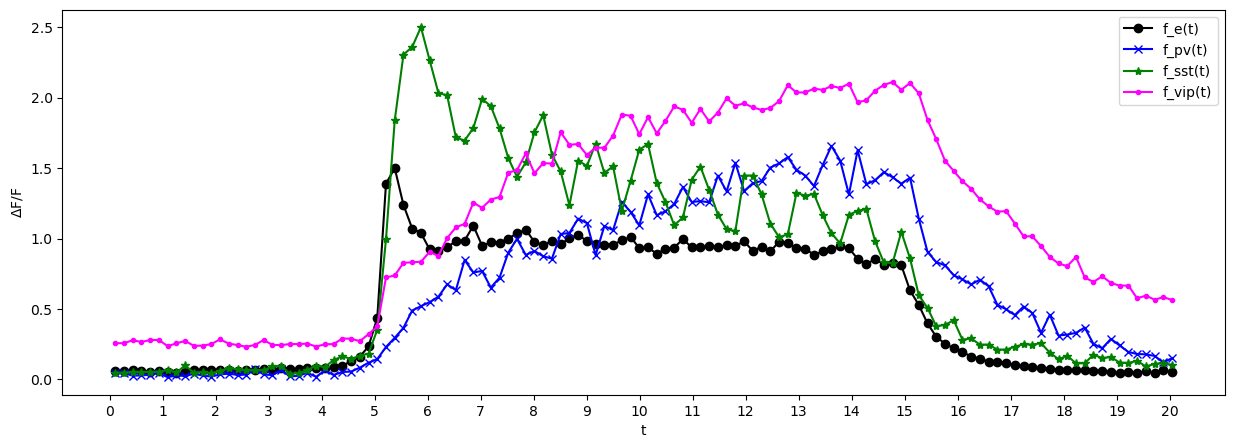

In [689]:
dt = 0.164745

t_exp_1_new = []
pc_sen_new = []
#f_e_avg_l = []
pv_new = []
#f_pv_excite = []
sst_new = []
vip_new = []
pc_na_new = []
pc_dep_new = []
pc_all_new = []
pc_sen_err_new = []
pc_dep_err_new = []
pc_na_err_new = []
pc_all_err_new = []
pv_err_new = []
sst_err_new = []
vip_err_new = []
pc_opto_pv_arch_new = []
pc_opto_pv_chr_new = []
pc_opto_sst_chr_new = []
pc_opto_sst_arch_new = []

for ind, time in np.ndenumerate(t_exp_1):
    if (time >= 5) and (time <= 25):
        t_exp_1_new.append(time - 5)
        pc_sen_new.append(pc_sen[ind])
        #f_e_avg_l.append(f_e_exp_3[ind])
        pv_new.append(pv[ind])
        sst_new.append(sst[ind])
        vip_new.append(vip[ind])
        pc_na_new.append(pc_na[ind])
        pc_dep_new.append(pc_dep[ind])
        pc_all_new.append(pc_all[ind])
        #f_pv_excite.append(pv_new[ind])
        pc_sen_err_new.append(pc_sen_err[ind])
        pc_dep_err_new.append(pc_dep_err[ind])
        pc_na_err_new.append(pc_na_err[ind])
        pv_err_new.append(pv_err[ind])
        sst_err_new.append(sst_err[ind])
        vip_err_new.append(vip_err[ind])
        pc_opto_pv_arch_new.append(pc_opto_pv_arch[ind])
        pc_opto_pv_chr_new.append(pc_opto_pv_chr[ind])
        pc_opto_sst_chr_new.append(pc_opto_sst_chr[ind])
        pc_opto_sst_arch_new.append(pc_opto_sst_arch[ind])
        pc_all_err_new.append(pc_all_err[ind])
        
        
pc_sen_new.insert(0, pc_sen_new[0])
pv_new.insert(0, pv_new[0])
sst_new.insert(0, sst_new[0])
vip_new.insert(0, vip_new[0])
pc_na_new.insert(0, pc_na_new[0])
pc_dep_new.insert(0, pc_dep_new[0])
pc_all_new.insert(0, pc_all_new[0])
pc_sen_err_new.insert(0, pc_sen_err_new[0])
pc_dep_err_new.insert(0, pc_dep_err_new[0])
pc_na_err_new.insert(0, pc_na_err_new[0])
pv_err_new.insert(0, pv_err_new[0])
sst_err_new.insert(0, sst_err_new[0])
vip_err_new.insert(0, vip_err_new[0])
pc_opto_pv_arch_new.insert(0, pc_opto_pv_arch_new[0])
pc_opto_pv_chr_new.insert(0, pc_opto_pv_chr_new[0])
pc_opto_sst_chr_new.insert(0, pc_opto_sst_chr_new[0])
pc_opto_sst_arch_new.insert(0, pc_opto_sst_arch_new[0])
pc_all_err_new.insert(0, pc_all_err_new[0])

#t_exp_1_new = np.linspace(start=0, stop=(len(pc_sen_new)-1)*dt, num=len(pc_sen_new))
t_exp_1_new.append(t_exp_1_new[-1] + dt)
        
plt.figure(figsize=(15,5))
plt.plot(t_exp_1_new, pc_all_new, color='black', marker='o', label='f_e(t)')
plt.plot(t_exp_1_new, pv_new, color='blue', marker='x', label='f_pv(t)')
plt.plot(t_exp_1_new, sst_new, color='green', marker='*', label='f_sst(t)')
plt.plot(t_exp_1_new, vip_new, color='magenta', marker='.', label='f_vip(t)')
#plt.plot(t_exp_1_new, f_pv_excite, color='orange', marker='v', label='external')

plt.legend(loc='best')
plt.ylabel(r'$\Delta$F/F')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [690]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp_1_new[30:91], data_pc_all[30:91], color='blue', marker='o', label='f_e(t)')
# plt.plot(t_exp_1_new[90:], vip_new[90:], color='black', marker='o', label='f_e(t)')

# plt.legend(loc='best')
# plt.ylabel(r'$\Delta$F/F')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,21,1))
# plt.grid()
# plt.show()

# Variables and constants

In [691]:
t = np.float32(np.array(t_exp_1_new))
t_exp = t
threshold = np.float32(0) 

power = np.float32(2.0)
q = np.float32(1.0)

ampl_1 = 1.0
# ampl_2 = 5.0
# ampl_3 = 0
# kl = 0
# kl_1 = 0
# kl_2 = 0
# s_1 = 0.10
# s_2 = 0.10

r_1 = np.float32(1.75749763)
delay_1 = np.float32(0.21187243)
delay_2 = np.float32(1.62946084)
delay_3 = np.float32(0.37943295)
decay = np.float32(3.54582748)
decay_s = np.float32(0.26803051)
decay_f = np.float32(0.5)
decay_ff = np.float32(1.70211256)
ampl = np.float32(1.0)
base = np.float32(1.0)
base_sigm = np.float32(0)

init = np.float32(np.array([0.055, 0.011, 0.017, 0.208, 0.055, 0.011, 0.017, 0.208]))
tau = np.float32(np.array([0.015, 0.0075, 0.019, 0.019]))
#tau_s = np.array([100, 1, 15, 0.5])
i = np.float32(np.array([0.25435776, 0.01401103, 0.02927017, 0.51027863]))
w = np.float32(np.array([
              0.06505351, # w_0  PC  -> PC        
              1.51655472, # w_1  FF  -> PC
              1.69971246, # w_2  SM   -> PC
              1.82141607, # w_3  PV -> PC
              0.62042205, # w_4  SST  -> PC
              0.19477673, # w_5  PC   -> PV
              0.57560143, # w_6  FF  -> PV
              2.09399360, # w_7  SM -> PV
              1.21895771, # w_8  PV   -> PV
              0.30590661, # w_9  SST  -> PV
              1.01472044, # w_10 PC -> SST
              0.59759942, # w_11 FB  -> SST
              0.22494105, # w_12 VIP  -> SST
              0.08938278, # w_13 PC  -> VIP
              0.00220557, # w_14 SST  -> VIP
              0.84651798, # w_15 SM  -> VIP
              0.74333759, # w_16 FB  -> PC
              0.43693422, # w_17 FB  -> PV
              0.02007970]))# w_18 FB -> VIP


# g = 1
# d = 0.9478
# s = 0.9999
# tau_d = 0.4429
# tau_s = 13.8823
# tau_e = 2e-3

data_pc_sen = np.float32(np.array(pc_sen_new)) * 0.333 #proportion of cells relative to PC
#data_pc_avg = f_e_avg_l
data_pv = np.float32(np.array(pv_new)) #proportion of cells relative to PC
data_sst = np.float32(np.array(sst_new)) #proportion of cells relative to PC
data_vip = np.float32(np.array(vip_new)) #proportion of cells relative to PC
data_pc_na = np.float32(np.array(pc_na_new)) * 0.333 #proportion of cells relative to PC
data_pc_dep = np.float32(np.array(pc_dep_new)) * 0.333 #proportion of cells relative to PC
data_pc_all = np.float32(np.array(pc_all_new))
data_pc_opto_pv_arch = np.float32(np.array(pc_opto_pv_arch_new))
data_pc_opto_pv_chr = np.float32(np.array(pc_opto_pv_chr_new))
data_pc_opto_sst_chr = np.float32(np.array(pc_opto_sst_chr_new))
data_pc_opto_sst_arch = np.float32(np.array(pc_opto_sst_arch_new))
pv_err_new = np.array(pv_err_new)
sst_err_new = np.array(sst_err_new)
vip_err_new = np.array(vip_err_new)

#data_pv_exc = f_pv_excite

count = 0
max_nfev = 2000

In [692]:
print(len(data_pc_sen))

122


In [693]:
# weights=np.zeros_like(data_pc)
# weights[18:]=1
# print(weights)

## Parameters

In [694]:
params = Parameters()
params.add('w_0', value = w[0] , vary = True, min = 0.0, max = 15)
params.add('w_1', value = w[1] , vary = True, min = 0.0, max = 15)
params.add('w_2', value = w[2] , vary = True, min = 0.0, max = 15)
params.add('w_3', value = w[3] , vary = True, min = 0.0, max = 15)
params.add('w_4', value = w[4] , vary = True, min = 0.0, max = 15)
params.add('w_5', value = w[5] , vary = True, min = 0.0, max = 15)
params.add('w_6', value = w[6] , vary = True, min = 0.0, max = 15)
params.add('w_7', value = w[7] , vary = True, min = 0.0, max = 15)
params.add('w_8', value = w[8] , vary = True, min = 0.0, max = 15)
params.add('w_9', value = w[9] , vary = True, min = 0.0, max = 15)
params.add('w_10', value = w[10] , vary = True, min = 0.0, max = 15)
params.add('w_11', value = w[11] , vary = True, min = 0.0, max = 15)
params.add('w_12', value = w[12] , vary = True, min = 0.0, max = 15)
params.add('w_13', value = w[13] , vary = True, min = 0.0, max = 15)
params.add('w_14', value = w[14] , vary = True, min = 0.0, max = 15)
params.add('w_15', value = w[15] , vary = True, min = 0.0, max = 15)
params.add('w_16', value = w[16] , vary = True, min = 0.0, max = 15)
params.add('w_17', value = w[17] , vary = True, min = 0.0, max = 15)
params.add('w_18', value = w[18] , vary = True, min = 0.0, max = 15)

#params.add('w_13', value = w[13] , vary = True, min = 0.1, max = 25)
params.add('tau_0', value = tau[0] , vary = False, min = 0.001, max = 0.03)
params.add('tau_1', value = tau[1] , vary = False, min = 0.001, max = 0.03)
params.add('tau_2', value = tau[2] , vary = False, min = 0.001, max = 0.03)
params.add('tau_3', value = tau[3] , vary = False, min = 0.001, max = 0.03)
params.add('threshold', value = threshold , vary = False, min = -np.inf, max = np.inf)
params.add('power', value = power , vary = False, min = 0.5, max = 2.5)
params.add('q', value = q, vary = False, min = 0.001, max = 2.5 )
params.add('i_0', value = i[0] , vary = True, min = 0.0, max = 0.7)
params.add('i_1', value = i[1] , vary = True, min = 0.0, max = 0.7)
params.add('i_2', value = i[2] , vary = True, min = 0.0, max = 0.7)
params.add('i_3', value = i[3] , vary = True, min = 0.0, max = 0.7)

params.add('ampl_1', value = ampl_1 , vary = False, min = 0.8, max = 1.5)
# params.add('ampl_2', value = ampl_2 , vary = True, min = 0, max = 15)
# params.add('ampl_3', value = ampl_3 , vary = False, min = 0, max = 7)
# params.add('kl', value = kl , vary = False, min = -15, max = 7)
# params.add('kl_1', value = kl_1 , vary = False, min = -10, max = 0)
# params.add('kl_2', value = kl_2 , vary = False, min = 0, max = 10)
# params.add('s_1', value = s_1 , vary = True, min = 0, max = 5)
# params.add('s_2', value = s_2 , vary = True, min = 0, max = 5)

params.add('r_1', value = r_1, vary = True, min = 0, max = 5)
params.add('delay_1', value = delay_1, vary = True, min = 0, max = 1.5)
params.add('delay_2', value = delay_2, vary = True, min = 0, max = 25)
params.add('delay_3', value = delay_3, vary = True, min = 0, max = 3)
params.add('decay', value = decay, vary = True, min = 0, max = 10)
params.add('decay_s', value = decay_s, vary = True, min = 0, max = 10)
params.add('decay_f', value = decay_f, vary = False, min = 0, max = 10)
params.add('decay_ff', value = decay_ff, vary = True, min = 0, max = 10)
params.add('ampl', value = ampl, vary = False, min = 0, max = 5)
params.add('base', value = base, vary = False, min = 0, max = 5)
params.add('base_sigm', value = base_sigm, vary = False, min = 0, max = 2)
# params.add('g', value = g , vary = False, min = 0.005, max = 1.0)
# params.add('d', value = d , vary = True, min = 0.4, max = 1.0)
# params.add('s', value = s , vary = True, min = 0.9, max = 1.0)
# params.add('tau_d', value = tau_d , vary = True, min = 0.3, max = 1.0)
# params.add('tau_s', value = tau_s , vary = True, min = 10.0, max = 30.0)
# params.add('tau_e', value = tau_e , vary = False, min = 0.0005, max = 50.0)
params

name,value,initial value,min,max,vary
w_0,0.06505351,0.06505350768566132,0.00000000,15.0000000,True
w_1,1.51655471,1.5165547132492065,0.00000000,15.0000000,True
w_2,1.69971251,1.6997125148773193,0.00000000,15.0000000,True
w_3,1.82141602,1.8214160203933716,0.00000000,15.0000000,True
w_4,0.62042207,0.6204220652580261,0.00000000,15.0000000,True
w_5,0.19477673,0.1947767287492752,0.00000000,15.0000000,True
w_6,0.57560146,0.5756014585494995,0.00000000,15.0000000,True
w_7,2.09399366,2.093993663787842,0.00000000,15.0000000,True
w_8,1.21895766,1.2189576625823975,0.00000000,15.0000000,True
w_9,0.30590662,0.30590662360191345,0.00000000,15.0000000,True


In [695]:
#print(f_s(t_exp[1]))

In [696]:
# heat = pd.DataFrame()
# heat[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
# heat['PC'] = [0.01222982, 2.25251760, 2.70988047, None, 0.97270781, 1.53293469, 1.32938450]
# heat['PV'] = [0.66931084, 1.39211370, 1.14684455, None, 0.22043244, 1.90878325, None]
# heat['SST'] = [0.17210378, None, None, 0.15543846, None, None, 0.65516905]
# heat['VIP'] = [0.04639222, None, 0.00206863, None, None, 0.79944357, None]
# heat.set_index('', inplace = True)

In [697]:
# heat_new = pd.DataFrame()
# heat_new[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
# heat_new['PC'] = [params["w_0"].value, params["w_3"].value, params["w_4"].value, None, params["w_1"].value, params["w_2"].value, params["w_16"].value]
# heat_new['PV'] = [params["w_5"].value, params["w_8"].value, params["w_9"].value, None, params["w_6"].value, params["w_7"].value, None]
# heat_new['SST'] = [params["w_10"].value, None, None, params["w_12"].value, None, None, params["w_11"].value]
# heat_new['VIP'] = [params["w_13"].value, None, params["w_14"].value, None, None, params["w_15"].value, None]
# heat_new.set_index('', inplace = True)

In [698]:
# fig, ax = plt.subplots(1, 2, figsize=(13, 5))
# sns.heatmap(heat, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black')
# sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black')
# ax[0].set_title("Old")
# ax[1].set_title("New")

In [699]:
print(len(t_exp), t_exp)

122 [ 0.107095  0.27184   0.436585  0.60133   0.766075  0.93082   1.095565
  1.26031   1.425055  1.5898    1.754545  1.91929   2.084035  2.24878
  2.413525  2.57827   2.743015  2.90776   3.072505  3.23725   3.401995
  3.56674   3.731485  3.89623   4.060975  4.22572   4.390465  4.55521
  4.719955  4.8847    5.049445  5.21419   5.378935  5.54368   5.708425
  5.87317   6.037915  6.20266   6.367405  6.53215   6.696895  6.86164
  7.026385  7.19113   7.355875  7.52062   7.685365  7.85011   8.014855
  8.1796    8.344345  8.50909   8.673835  8.83858   9.003325  9.16807
  9.332815  9.49756   9.662305  9.82705   9.991795 10.15654  10.321285
 10.48603  10.650775 10.81552  10.980265 11.14501  11.309755 11.4745
 11.639245 11.80399  11.968735 12.13348  12.298225 12.46297  12.627715
 12.79246  12.957205 13.12195  13.286695 13.45144  13.616185 13.78093
 13.945675 14.11042  14.275165 14.43991  14.604655 14.7694   14.934145
 15.09889  15.263635 15.42838  15.593125 15.75787  15.922615 16.08736
 16.252106

In [700]:
w_0 = params['w_0'].value
w_1 = params['w_1'].value
w_2 = params['w_2'].value
w_3 = params['w_3'].value
w_4 = params['w_4'].value
w_5 = params['w_5'].value
w_6 = params['w_6'].value
w_7 = params['w_7'].value
w_8 = params['w_8'].value
w_9 = params['w_9'].value
w_10 = params['w_10'].value
w_11 = params['w_11'].value
w_12 = params['w_12'].value
w_13 = params['w_13'].value
w_14 = params['w_14'].value
w_15 = params['w_15'].value
w_16 = params['w_16'].value
w_17 = params['w_17'].value
w_18 = params['w_18'].value
    
tau_0 = params['tau_0'].value
tau_1 = params['tau_1'].value
tau_2 = params['tau_2'].value
tau_3 = params['tau_3'].value
threshold = params['threshold'].value
power = params['power'].value
q = params['q'].value
i_0 = params['i_0'].value
i_1 = params['i_1'].value
i_2 = params['i_2'].value
i_3 = params['i_3'].value
ampl_1 = params['ampl_1'].value
#     ampl_2 = params['ampl_2'].value
#     ampl_3 = params['ampl_3'].value
#     kl = params['kl'].value
#     kl_1 = params['kl_1'].value
#     kl_2 = params['kl_2'].value
#     s_1 = params['s_1'].value
#     s_2 = params['s_2'].value
r_1 = params['r_1'].value
delay_1 = params['delay_1'].value
delay_2 = params['delay_2'].value
delay_3 = params['delay_3'].value
decay = params['decay'].value
decay_s = params['decay_s'].value
decay_f = params['decay_f'].value
decay_ff = params['decay_ff'].value
ampl = params['ampl'].value
base = params['base'].value
base_sigm = params['base_sigm'].value

In [701]:
%matplotlib inline
from ipywidgets import interactive, fixed
import ipywidgets as widgets
interactive(slider, 
            w_0 = fixed(w_0), # widgets.IntSlider(min=0, max=2, step=0.1, value=w_0)
            w_1=fixed(w_1), w_2=fixed(w_2), w_3=widgets.FloatSlider(min=0, max=5, step=0.1, value=w_3), w_4=widgets.FloatSlider(min=0, max=7, step=0.1, value=w_4), w_5=fixed(w_5), 
            w_6=fixed(w_6), w_7=widgets.FloatSlider(min=0, max=3, step=0.1, value=w_7), w_8=fixed(w_8), w_9=fixed(w_9), w_10=fixed(w_10), 
            w_11=fixed(w_11), w_12=fixed(w_12), w_13=fixed(w_13), w_14=fixed(w_14), w_15=fixed(w_15), 
            w_16=fixed(w_16), w_17=fixed(w_17), w_18=fixed(w_18), 
            tau_0=fixed(tau_0), tau_1=fixed(tau_1), tau_2=fixed(tau_2), tau_3=fixed(tau_3),
            threshold=fixed(threshold), power=fixed(power), q=fixed(q),
            i_0=fixed(i_0), i_1=fixed(i_1), i_2=fixed(i_2), i_3=fixed(i_3),
            r_1=fixed(r_1), decay=fixed(decay), delay_1=fixed(delay_1), delay_2=fixed(delay_2), delay_3=fixed(delay_3), ampl=fixed(ampl),
            base=fixed(base), decay_s=fixed(decay_s), ampl_1=fixed(ampl_1), base_sigm=fixed(base_sigm), decay_f=fixed(decay_f), decay_ff=fixed(decay_ff))

interactive(children=(FloatSlider(value=1.8214160203933716, description='w_3', max=5.0), FloatSlider(value=0.6…

In [702]:
#model = simulate_step(t_exp, init, params)
#print(model, 2*'\n', len(model))

In [703]:
# plt.plot(model['t'], model['f_e'])
# plt.ylim(0,5)
# plt.show()

In [704]:
model = simulate_step(t_exp, init, params)

In [707]:
# display.display(display.HTML(model[['t', 'f_e_o']].to_html()))
model[['t', 'f_e_o']].to_csv('out_sst_chr_2024-11-06.csv', index=False)
#model[['t', 'f_e', 'f_pv', 'f_sst', 'f_vip']].to_csv('out_naive_2024-11-06.csv', index=False)

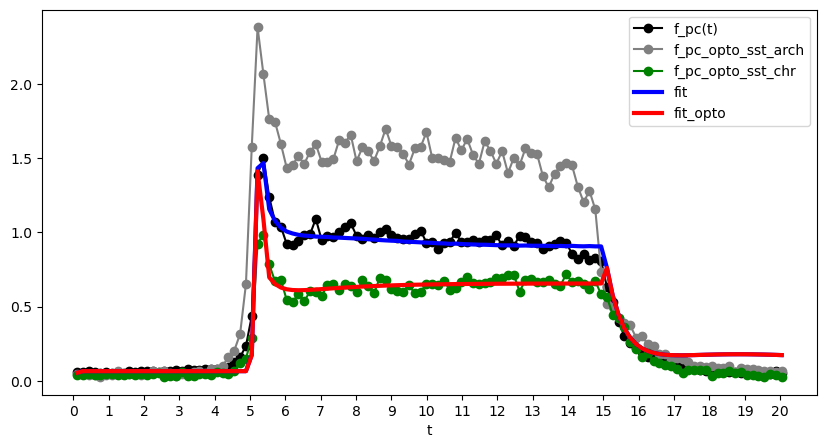

In [706]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
#plt.plot(t_exp, data_pc_opto_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_opto_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
plt.plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
plt.plot(t_exp, data_pc_opto_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_e_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
#plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [49]:
print(model['f_e_o'].values)
print(model['f_e'].values)
for i,t in enumerate(t_exp):
    print(t, data_sst[i])

[0.055      0.0658946  0.06589751 0.06589829 0.06589859 0.06589791
 0.06589853 0.06589865 0.06589737 0.0658986  0.06589809 0.06589855
 0.06589871 0.06589832 0.06589723 0.06589808 0.06589857 0.065898
 0.06589923 0.06589734 0.0658981  0.06589935 0.06589864 0.06589909
 0.0658975  0.06589814 0.06589767 0.06589876 0.06589919 0.06589765
 0.17859739 1.43975285 2.14826077 1.88428252 1.78899463 1.74114869
 1.72080707 1.71703894 1.72119953 1.732998   1.74498087 1.75393701
 1.76684995 1.77374353 1.78130479 1.78461484 1.78496642 1.78275255
 1.77654295 1.76626017 1.75078441 1.73105334 1.71183707 1.6914141
 1.67560231 1.65622779 1.63833574 1.62508644 1.60954039 1.5967506
 1.58139684 1.5700911  1.56001854 1.5518491  1.53971179 1.53300382
 1.52167091 1.51404808 1.50784574 1.50226046 1.4952405  1.48949219
 1.48574926 1.47938392 1.47619733 1.47232494 1.46831058 1.46476628
 1.46253256 1.4592303  1.45811946 1.45377591 1.45244073 1.45084458
 1.44836575 1.44818989 1.44574011 1.4436606  1.44528458 1.44114242

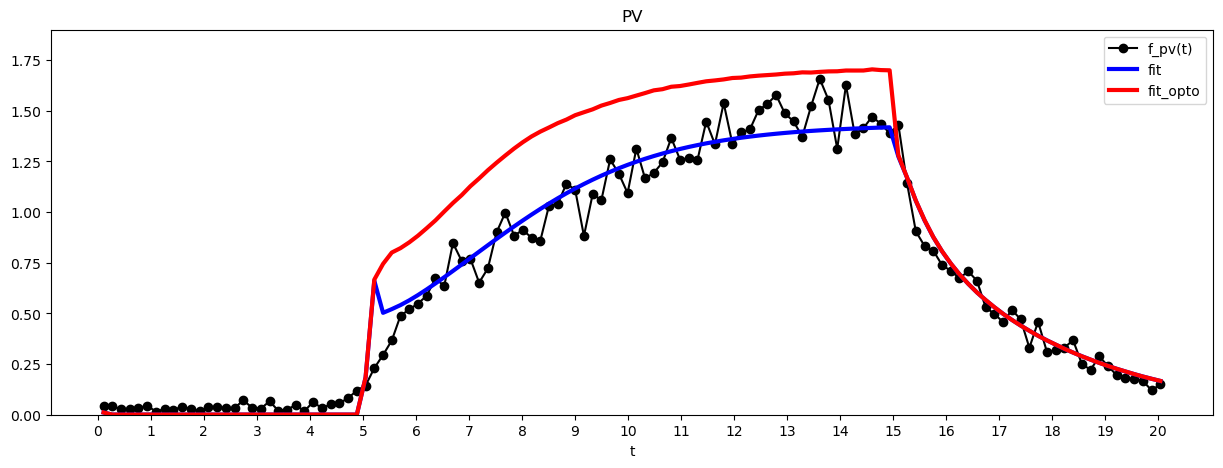

In [50]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, data_pc_all, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, fast, color='green', label='fit', linewidth=3)
#plt.plot(t_exp, slow, color='orange', label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.9)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [51]:
print(model['f_pv'].values)
print(model['f_pv_o'].values)
print(model['f_pv'].values/model['f_pv_o'].values)

[1.09999999e-02 6.74033783e-04 6.73281088e-04 6.74252047e-04
 6.74628147e-04 6.73779707e-04 6.74548834e-04 6.74698686e-04
 6.73107601e-04 6.74636075e-04 6.73998293e-04 6.74577554e-04
 6.74767290e-04 6.74283637e-04 6.72942490e-04 6.73990192e-04
 6.74605603e-04 6.73896657e-04 6.75414210e-04 6.73067649e-04
 6.74019482e-04 6.75570455e-04 6.74687802e-04 6.75244471e-04
 6.73271760e-04 6.74066870e-04 6.73478882e-04 6.74841222e-04
 6.75365300e-04 6.73458303e-04 1.83152212e-01 6.60985409e-01
 5.02896695e-01 5.21182755e-01 5.41158830e-01 5.64512137e-01
 5.90549975e-01 6.18562857e-01 6.47993532e-01 6.78429347e-01
 7.09554416e-01 7.41118547e-01 7.72908586e-01 8.04733236e-01
 8.36417409e-01 8.67798935e-01 8.98728002e-01 9.29066249e-01
 9.58689598e-01 9.87487501e-01 1.01536507e+00 1.04224195e+00
 1.06805294e+00 1.09275003e+00 1.11629678e+00 1.13867355e+00
 1.15987086e+00 1.17989063e+00 1.19874702e+00 1.21646051e+00
 1.23306038e+00 1.24858066e+00 1.26306075e+00 1.27654381e+00
 1.28907666e+00 1.300705

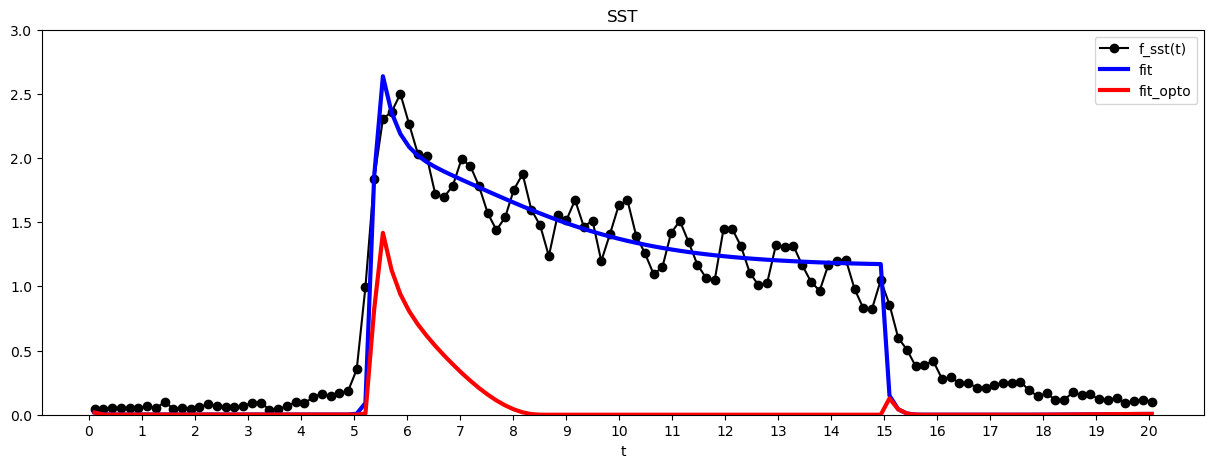

In [52]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 3.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [53]:
print(model['f_sst'].values)
print(model['f_sst_o'].values)
print(model['f_sst'].values/model['f_sst_o'].values)

[1.70000009e-02 1.32613133e-03 1.32401864e-03 1.32398336e-03
 1.32396984e-03 1.32400035e-03 1.32397270e-03 1.32396732e-03
 1.32402451e-03 1.32396956e-03 1.32399250e-03 1.32397167e-03
 1.32396485e-03 1.32398223e-03 1.32403044e-03 1.32399279e-03
 1.32397066e-03 1.32399613e-03 1.32394157e-03 1.32402595e-03
 1.32399173e-03 1.32393596e-03 1.32396769e-03 1.32394770e-03
 1.32401861e-03 1.32399003e-03 1.32401115e-03 1.32396218e-03
 1.32394335e-03 1.32401190e-03 7.37814137e-03 9.13567798e-02
 1.85903315e+00 2.63729616e+00 2.35316664e+00 2.18806577e+00
 2.08652326e+00 2.01906369e+00 1.96981464e+00 1.93017115e+00
 1.89547304e+00 1.86322396e+00 1.83212394e+00 1.80153694e+00
 1.77119467e+00 1.74103063e+00 1.71108643e+00 1.68145944e+00
 1.65227044e+00 1.62364674e+00 1.59571057e+00 1.56857369e+00
 1.54233366e+00 1.51707086e+00 1.49285031e+00 1.46971972e+00
 1.44771145e+00 1.42684358e+00 1.40712035e+00 1.38853525e+00
 1.37107160e+00 1.35470403e+00 1.33940079e+00 1.32512430e+00
 1.31183271e+00 1.299481

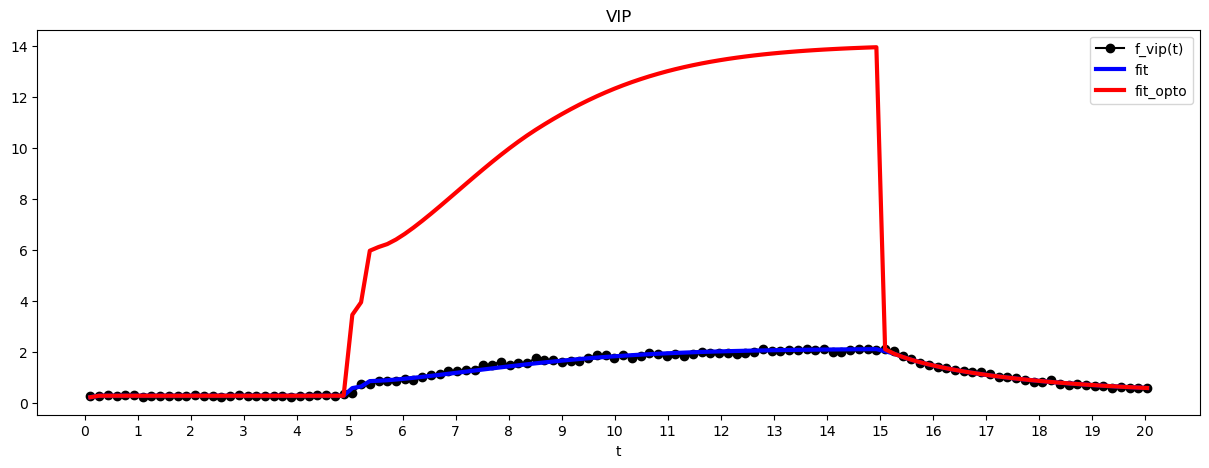

In [54]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [55]:
print(model['f_vip'].values)
print(model['f_vip_o'].values)

[0.208      0.26623697 0.26625011 0.26625007 0.26625005 0.26625009
 0.26625005 0.26625005 0.26625012 0.26625005 0.26625008 0.26625005
 0.26625004 0.26625006 0.26625012 0.26625008 0.26625005 0.26625008
 0.26625002 0.26625012 0.26625008 0.26625001 0.26625005 0.26625002
 0.26625011 0.26625007 0.2662501  0.26625004 0.26625002 0.2662501
 0.56710025 0.62876235 0.84011414 0.85384037 0.87444536 0.90201048
 0.93416882 0.9694695  1.00700335 1.04617227 1.08655366 1.12781992
 1.16969559 1.21193327 1.25430115 1.29657908 1.33855742 1.38003666
 1.4208309  1.4607685  1.49969511 1.53747432 1.57398893 1.6091427
 1.64285817 1.67507762 1.70576237 1.73489059 1.76245696 1.78846978
 1.81294981 1.83592942 1.85744897 1.87755673 1.89630658 1.91375667
 1.92996815 1.9450043  1.95892889 1.97180595 1.98369885 1.99466971
 2.00477869 2.01408418 2.02264203 2.03050547 2.03772533 2.04434941
 2.05042286 2.05598811 2.06108483 2.06575015 2.07001857 2.0739222
 2.07749084 2.0807521  2.08373145 2.0864525  2.08893697 2.0912048

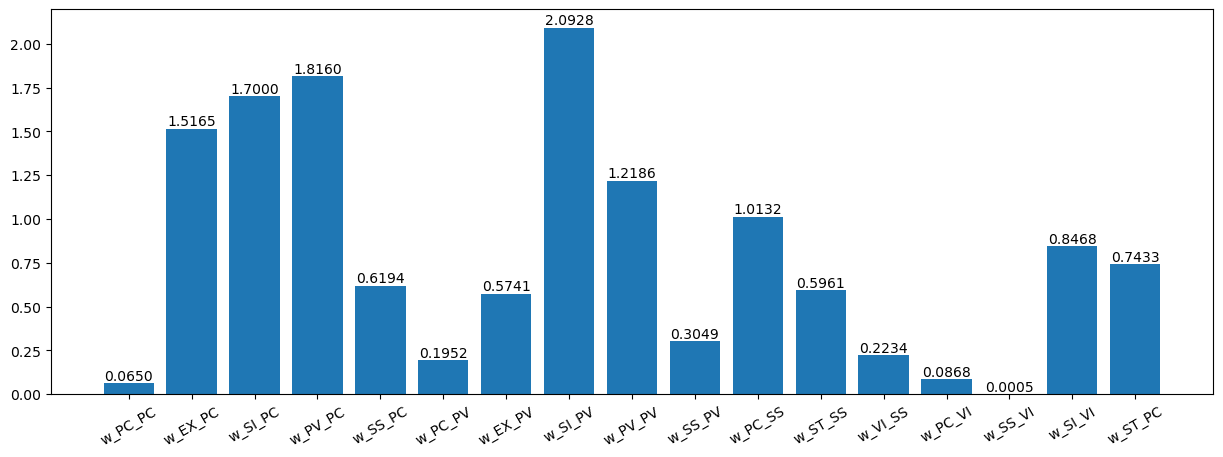

In [56]:
vals = []
for _, param in params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

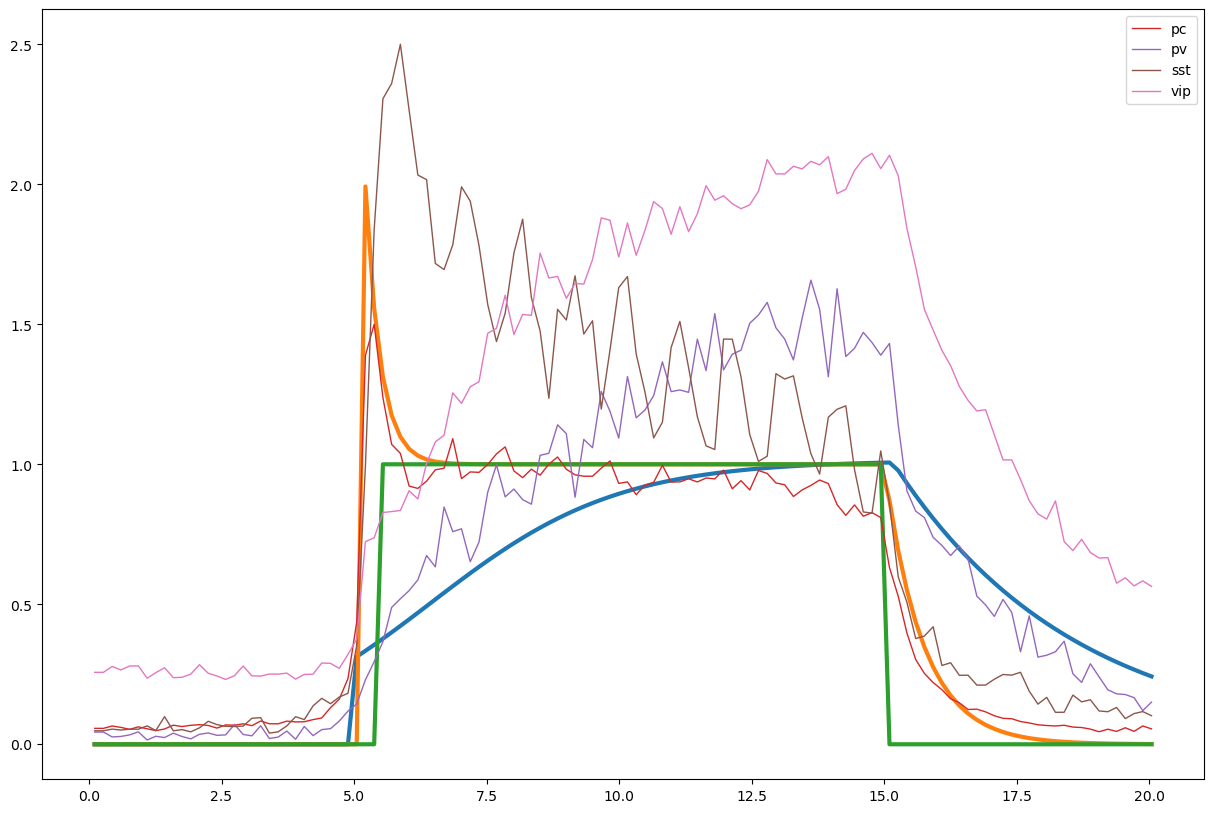

'\n ampl_1:     1.01359931 (init = 1)\n    r_1:        1.75139660 (init = 1.638479)\n    delay_1:    0.21200599 (init = 0.2032416)\n    delay_2:    1.45963700 (init = 1.400737)\n    delay_3:    0.41140712 (init = 0.363557)\n    decay:      3.51342590 (init = 3.702939)\n    decay_s:    0.29203316 (init = 0.3060473)\n    decay_f:    0.5 (fixed)\n    decay_ff:   1.39646321 (init = 0.5)\n    ampl:       1.05399785 (init = 1.093407)\n    base:       1 (fixed)\n    base_sigm:  0 (fixed)\n'

In [57]:
sig = []
ex = []
st = []
for i in t_exp:
    sig.append(Sigm(i, ampl = 1.01359931, rate = 1.75139660, delay = 1.45963700, decay_s = 0.29203316, base = 0))
    ex.append(expon(i, ampl = ampl, base = 1, decay = 3.51342590, delay = 0.21200599, decay_ff = 1.39646321))
    st.append(Step(i, k = 0, delay = 0.41140712, decay_f = 0.5))
    
plt.figure(figsize = (15,10))
plt.plot(t_exp, np.array(sig), linewidth = 3)
plt.plot(t_exp, np.array(ex), linewidth = 3)
plt.plot(t_exp, np.array(st), linewidth = 3)
plt.plot(t_exp, data_pc_all, label = 'pc', linewidth = 1)
plt.plot(t_exp, data_pv, label = 'pv', linewidth = 1)
plt.plot(t_exp, data_sst, label = 'sst', linewidth = 1)
plt.plot(t_exp, data_vip, label = 'vip', linewidth = 1)
plt.legend()
#plt.xlim(4.5, 5.5)
plt.show()


"""
 ampl_1:     1.01359931 (init = 1)
    r_1:        1.75139660 (init = 1.638479)
    delay_1:    0.21200599 (init = 0.2032416)
    delay_2:    1.45963700 (init = 1.400737)
    delay_3:    0.41140712 (init = 0.363557)
    decay:      3.51342590 (init = 3.702939)
    decay_s:    0.29203316 (init = 0.3060473)
    decay_f:    0.5 (fixed)
    decay_ff:   1.39646321 (init = 0.5)
    ampl:       1.05399785 (init = 1.093407)
    base:       1 (fixed)
    base_sigm:  0 (fixed)
"""

In [58]:
inp = pd.DataFrame()
inp['t'] = t_exp
inp['FF'] = ex
inp['SM'] = sig
inp['FB'] = st
inp

,t,FF,SM,FB
0,0.107095,0.000000,0.000000,0.0
1,0.271840,0.000000,0.000000,0.0
2,0.436585,0.000000,0.000000,0.0
3,0.601330,0.000000,0.000000,0.0
4,0.766075,0.000000,0.000000,0.0
...,...,...,...,...
117,19.382259,0.002199,0.293739,0.0
118,19.547005,0.001747,0.279942,0.0
119,19.711750,0.001388,0.266792,0.0
120,19.876495,0.001103,0.254260,0.0


In [59]:
inp[['t', 'FF', 'SM', 'FB']].to_csv('out_inputs.csv', index=False)

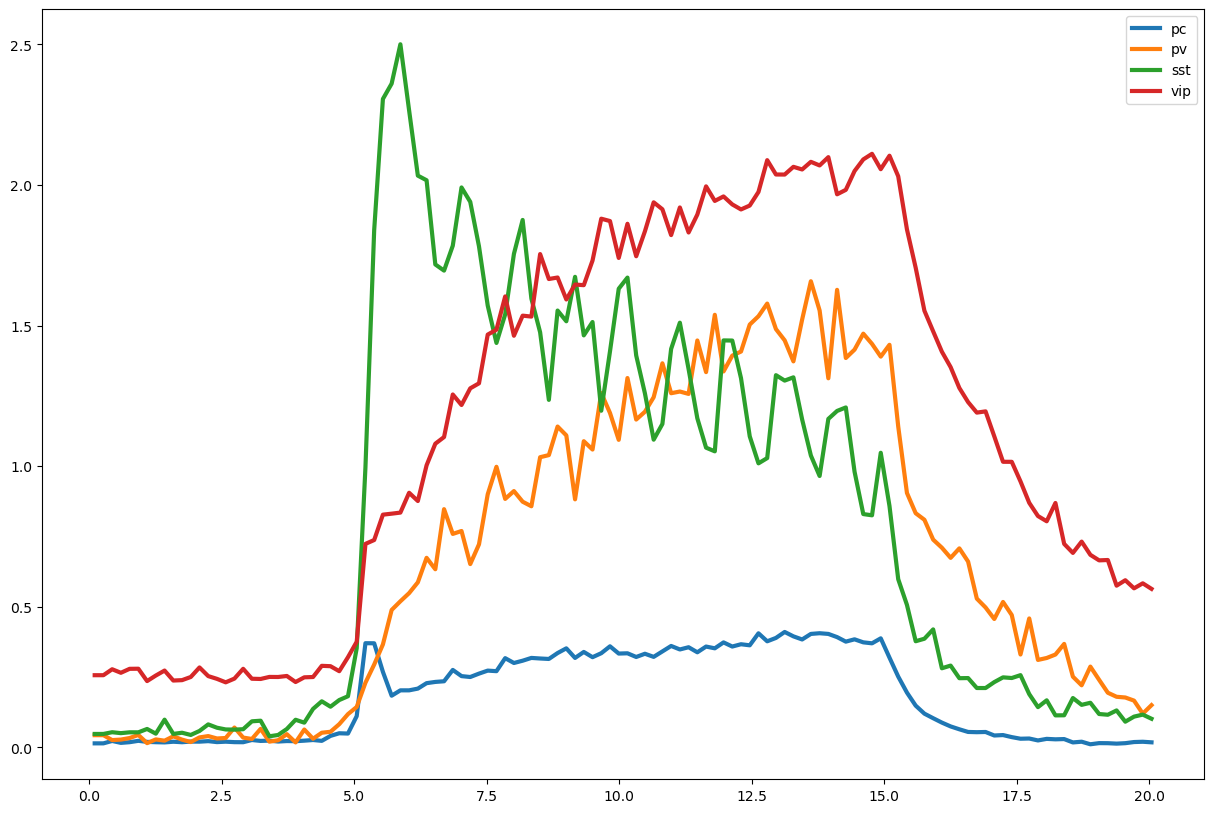

In [60]:
plt.figure(figsize = (15,10))
# plt.plot(t_exp, np.array(sig)*1.4 +0.4)
# plt.plot(t_exp, np.array(ex))
# plt.plot(t_exp, np.array(st))
plt.plot(t_exp, data_pc_sen, label = 'pc', linewidth = 3)
plt.plot(t_exp, data_pv, label = 'pv', linewidth = 3)
plt.plot(t_exp, data_sst, label = 'sst', linewidth = 3)
plt.plot(t_exp, data_vip, label = 'vip', linewidth = 3)
plt.legend()
#plt.xlim(4.5, 5.5)
plt.show()

In [61]:
for i in t_exp:
    print(i, expon(i, ampl = 0.5, base = 1.05259920, decay = 5.12622052, delay = 0.54586319))

0.107095 0
0.27184 0
0.436585 0
0.60133 0
0.766075 0
0.93082 0
1.095565 0
1.26031 0
1.425055 0
1.5898 0
1.754545 0
1.91929 0
2.084035 0
2.24878 0
2.413525 0
2.57827 0
2.743015 0
2.90776 0
3.072505 0
3.23725 0
3.401995 0
3.56674 0
3.731485 0
3.89623 0
4.060975 0
4.22572 0
4.390465 0
4.55521 0
4.719955 0
4.8847 0
5.049445 0
5.21419 0
5.378935 0
5.54368 0
5.708425 1.2698994812343423
5.87317 1.1459870947664559
6.037915 1.0927338814707015
6.20266 1.0698476517202675
6.367405 1.0600119681058982
6.53215 1.0557849428065416
6.696895 1.053968315056163
6.86164 1.053187596720252
7.026385 1.052852071881618
7.19113 1.0527078750316732
7.355875 1.0526459046446695
7.52062 1.0526192719870988
7.685365 1.0526078262016154
7.85011 1.052602907233162
8.014855 1.0526007932324255
8.1796 1.0525998847160296
8.344345 1.052599494265759
8.50909 1.0525993264645974
8.673835 1.052599254350097
8.83858 1.0525992233576722
9.003325 1.0525992100382682
9.16807 1.0525992043140995
9.332815 1.052599201854041
9.49756 1.0525992007

# Solve

## leastsq (Levenberg-Marquardt)

In [62]:
count = 0

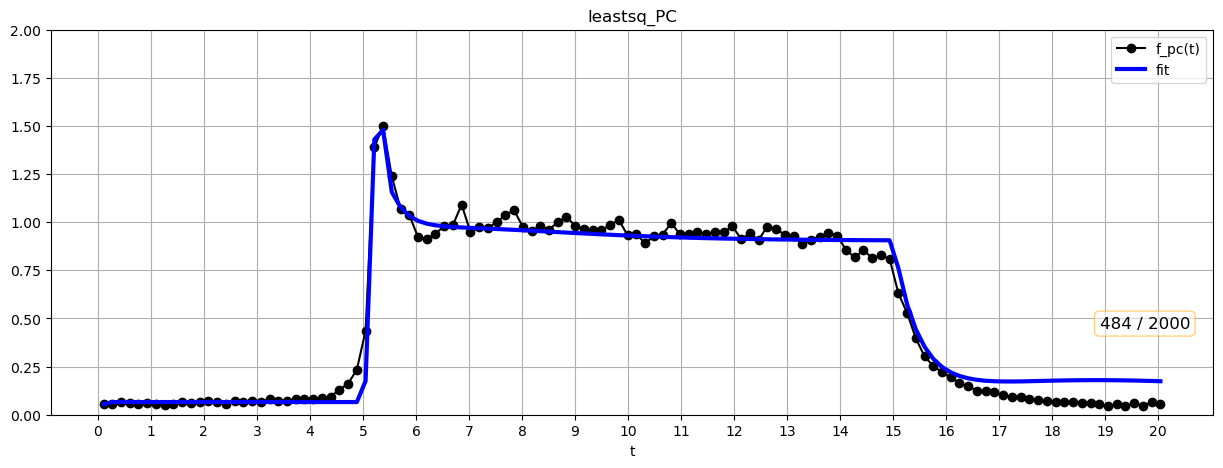


CPU times: total: 6min 11s
Wall time: 6min 12s


In [63]:
%%time
%matplotlib inline

result_leastsq = minimize(residual_step, params, method='least_squares', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=3*max_nfev, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [64]:
report_fit(result_leastsq)

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 484
    # data points      = 488
    # variables        = 30
    chi-square         = 69.1604862
    reduced chi-square = 0.15100543
    Akaike info crit   = -893.496229
    Bayesian info crit = -767.786767
##  Warning: uncertainties could not be estimated:
    delay_3:    at initial value
[[Variables]]
    w_0:        0.06505351 (init = 0.06503985)
    w_1:        1.51655472 (init = 1.516523)
    w_2:        1.69971246 (init = 1.7)
    w_3:        1.82141607 (init = 1.816027)
    w_4:        0.62042205 (init = 0.6194496)
    w_5:        0.19477673 (init = 0.1952436)
    w_6:        0.57560143 (init = 0.5740777)
    w_7:        2.09399360 (init = 2.09275)
    w_8:        1.21895771 (init = 1.218565)
    w_9:        0.30590661 (init = 0.3048944)
    w_10:       1.01472044 (init = 1.01315)
    w_11:       0.59759942 (init = 0.5960765)
    w_12:       0.22494105 (init = 0.2233754)
    w_13:       0.08938278

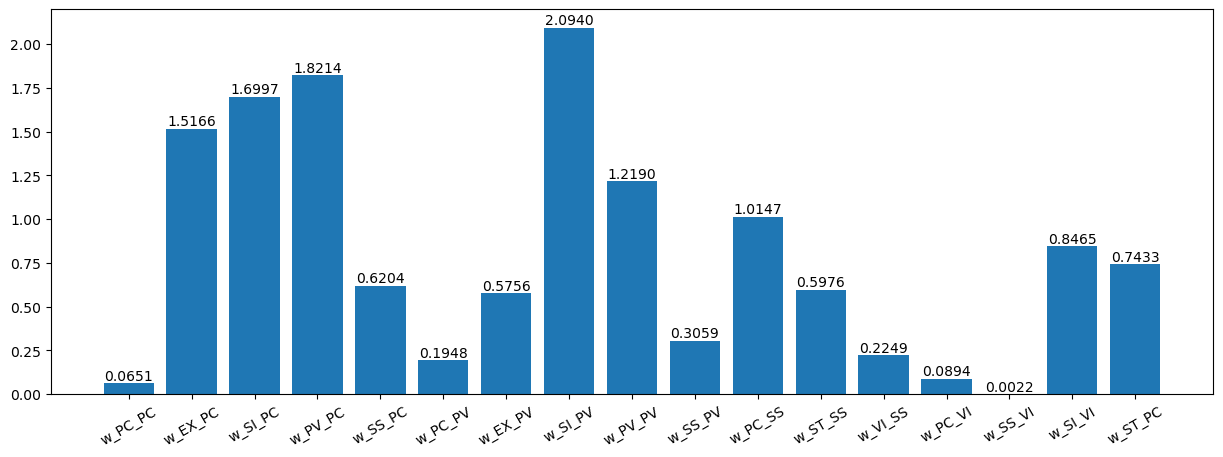

In [65]:
vals = []
for _, param in result_leastsq.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

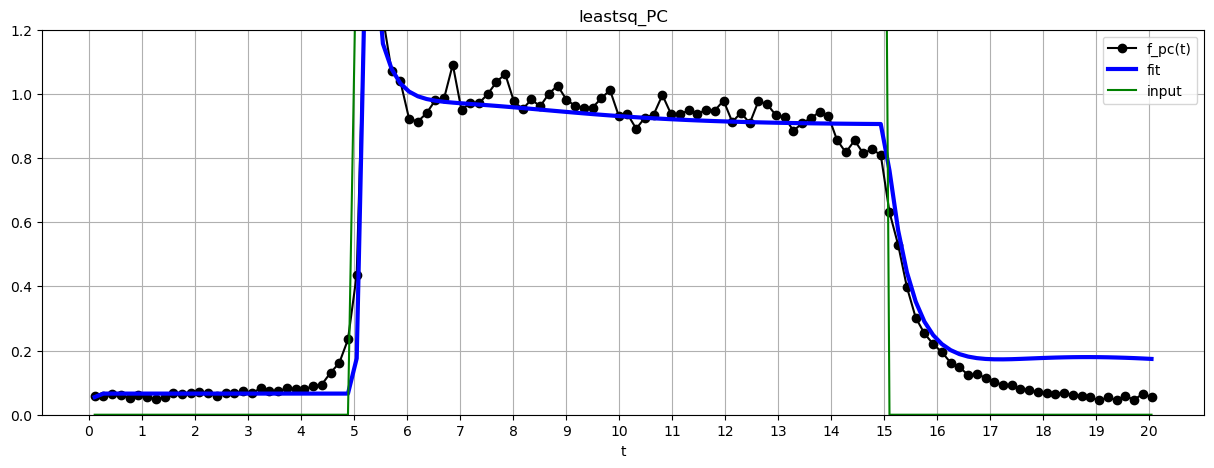

In [66]:
sim_leastsq = simulate_step(t_exp, init, params)
fit_leastsq = simulate_step(t_exp, init, result_leastsq.params)
step = []

for i in t_exp:
    step.append(Step(i))
    
curve = np.array(step) * result_leastsq.params['w_1'].value
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsq['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()

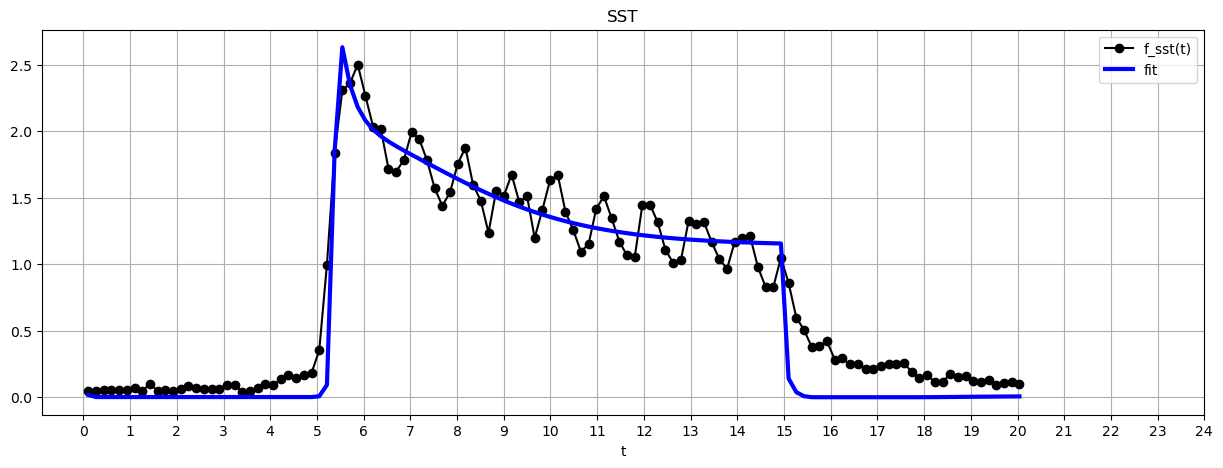

In [67]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsq['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

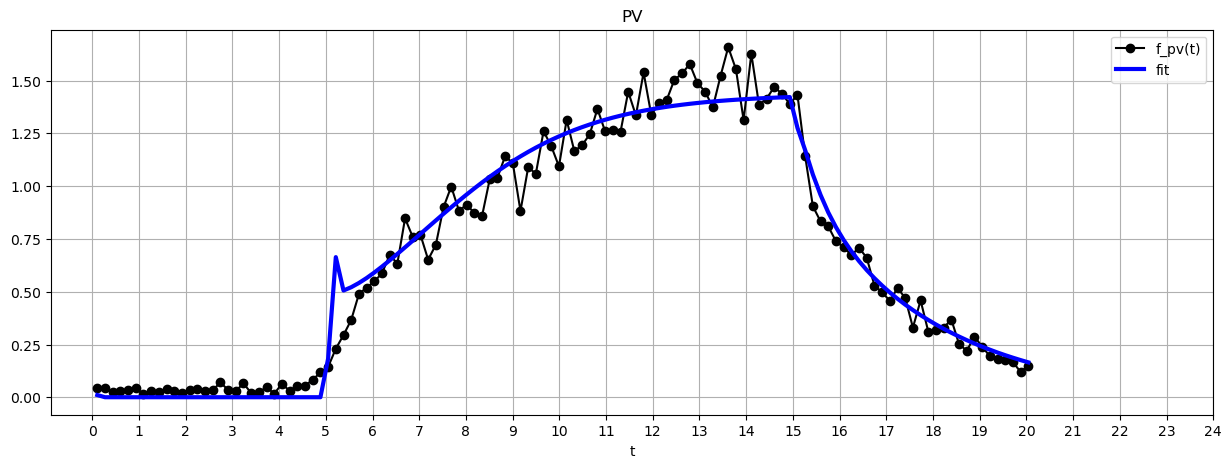

In [68]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsq['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

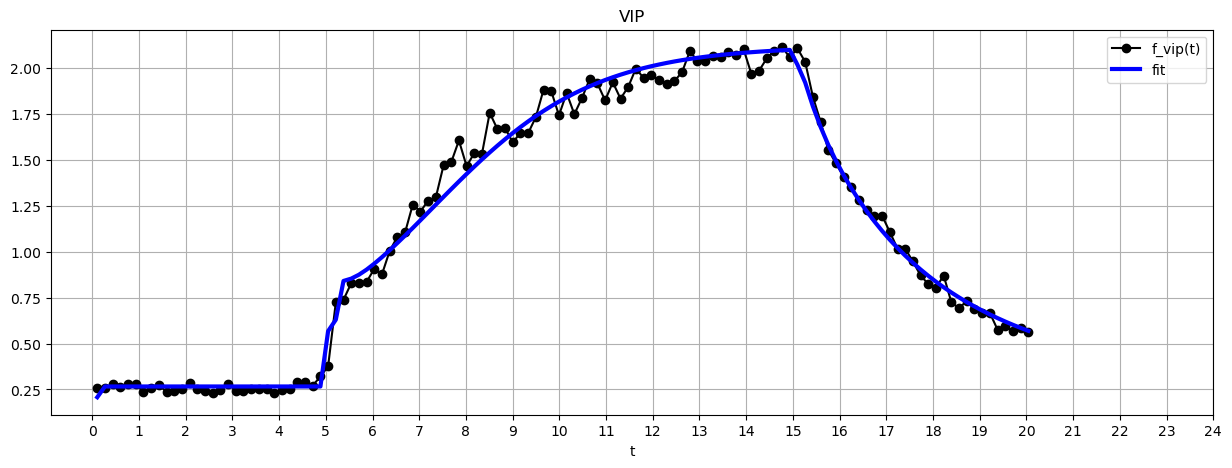

In [69]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsq['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

## least_squares

In [70]:
count = 0

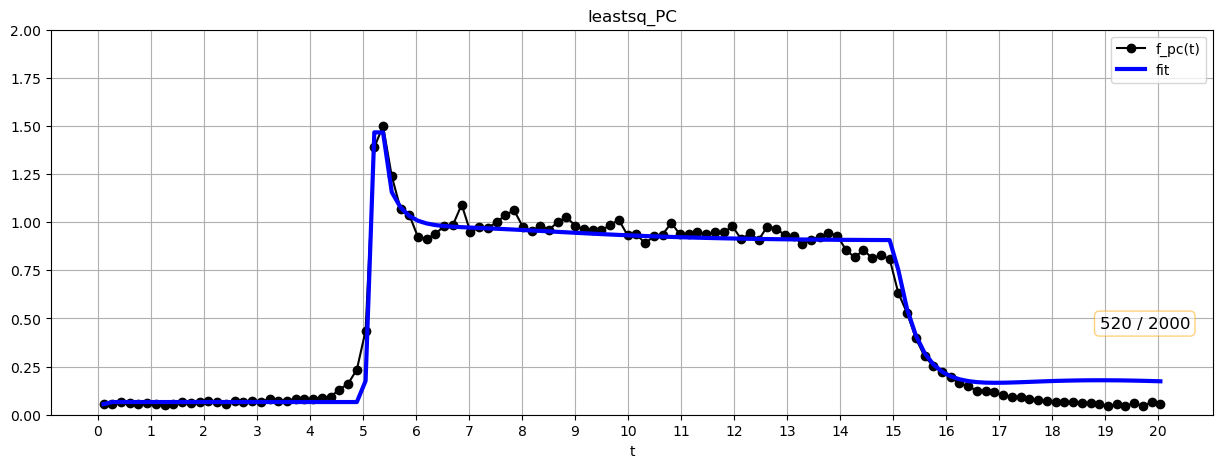


CPU times: total: 6min 31s
Wall time: 6min 32s


In [71]:
%%time
%matplotlib inline

result_leastsqs = minimize(residual_step, params, method='leastsq', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=3*max_nfev, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [72]:
report_fit(result_leastsqs)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 518
    # data points      = 488
    # variables        = 30
    chi-square         = 68.9541132
    reduced chi-square = 0.15055483
    Akaike info crit   = -894.954585
    Bayesian info crit = -769.245123
##  Warning: uncertainties could not be estimated:
    w_1:        at initial value
    w_3:        at initial value
    w_6:        at initial value
    w_8:        at initial value
    w_9:        at initial value
    w_10:       at initial value
    i_1:        at initial value
    i_2:        at initial value
    delay_2:    at initial value
    delay_3:    at initial value
[[Variables]]
    w_0:        0.06500499 (init = 0.06503985)
    w_1:        1.51652012 (init = 1.516523)
    w_2:        1.69617729 (init = 1.7)
    w_3:        1.81602699 (init = 1.816027)
    w_4:        0.61924941 (init = 0.6194496)
    w_5:        0.19519821 (init = 0.1952436)
    w_6:        0.57407235 (init = 0.5740777)
    w_

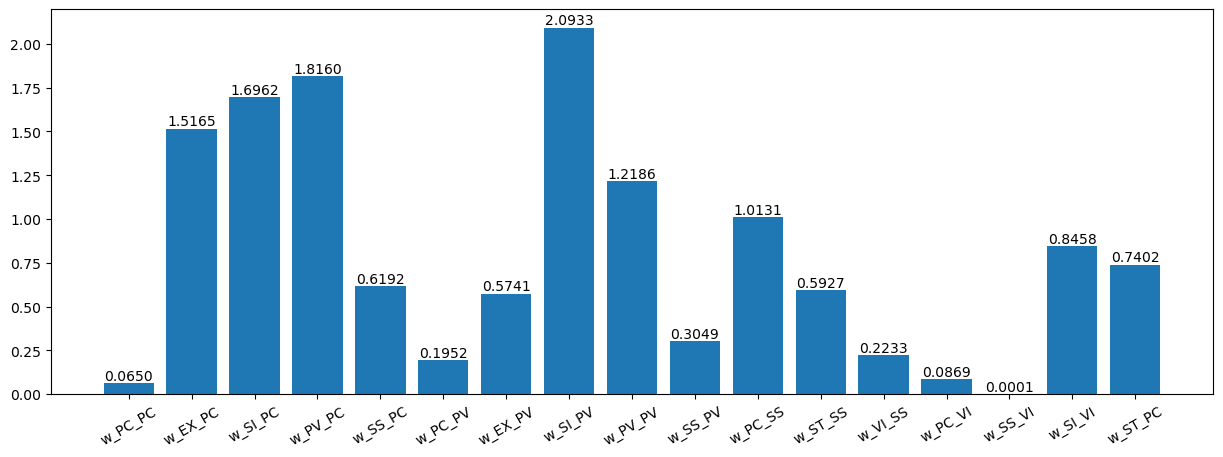

In [73]:
vals = []
for _, param in result_leastsqs.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

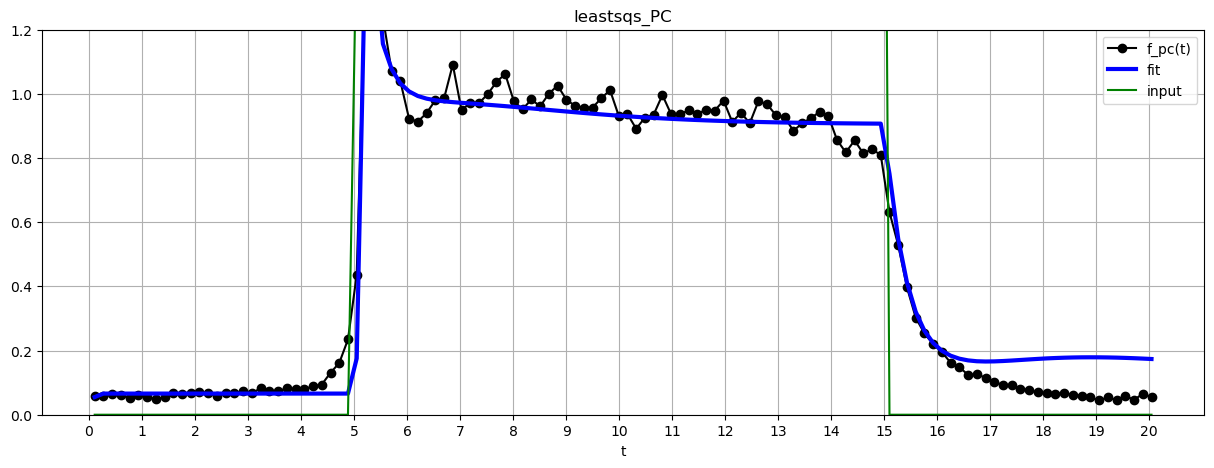

In [74]:
sim_leastsqs = simulate_step(t_exp, init, params)
fit_leastsqs = simulate_step(t_exp, init, result_leastsqs.params)
step = []

for i in t_exp:
    step.append(Step(i))
    
curve = np.array(step) * result_leastsqs.params['w_1'].value
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsqs['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsqs_PC')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()

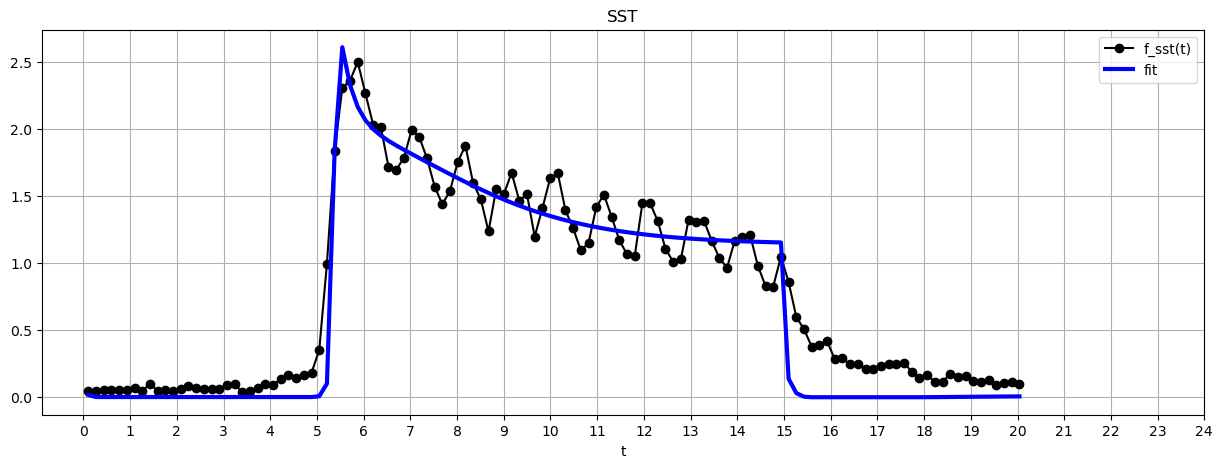

In [75]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsqs['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

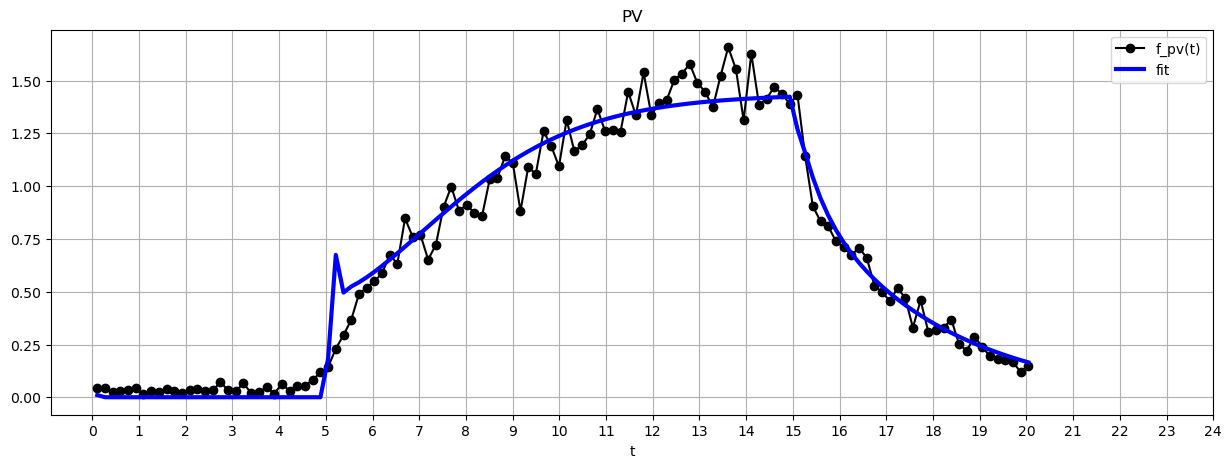

In [76]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsqs['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

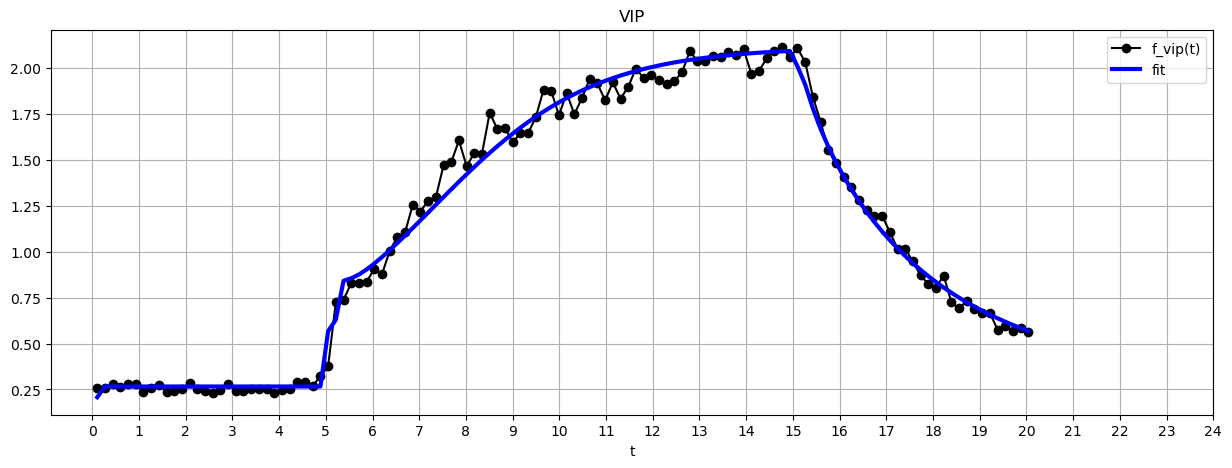

In [77]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsqs['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

## nelder

In [78]:
count = 0

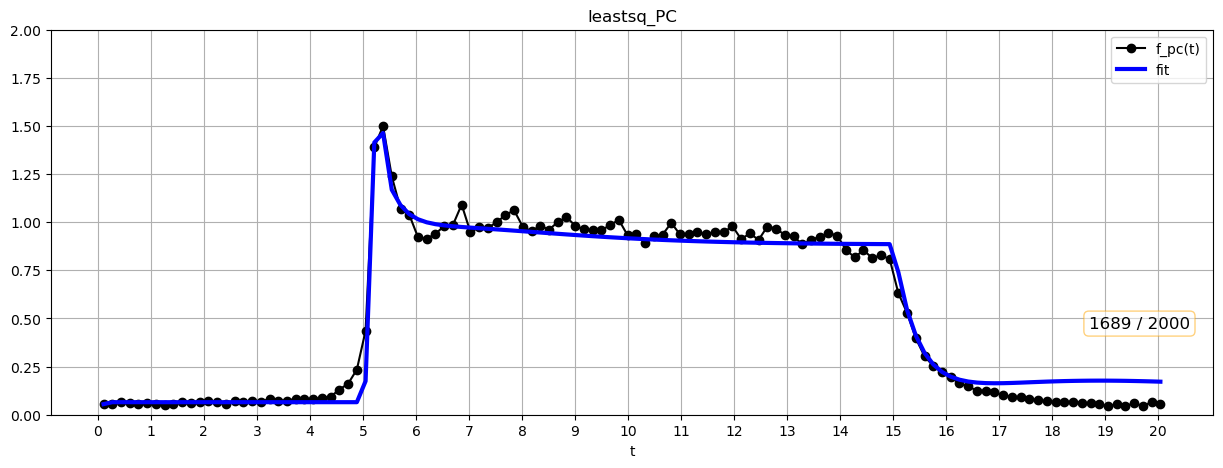

KeyboardInterrupt: 

In [79]:
%%time

%matplotlib inline

result_nelder = minimize(residual_step, params, method='nelder', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', options = {'adaptive' : True}, max_nfev = 4500)
print()


In [80]:
report_fit(result_nelder)

NameError: name 'result_nelder' is not defined

In [ ]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

In [ ]:
sim_nelder = simulate_step(t_exp, init, params)
fit_nelder = simulate_step(t_exp, init, result_nelder.params)
step_pv = []
#step_sst = []
# step = []

# for i in t_exp:
#     #step_sst.append(f_s(i, data_sst_exc))
#     step.append(Step(i, amp = 0.5, base = 0.0))
    
# curve =np.array(step) * result_nelder.params['w_2'].value

plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_nelder['f_e'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('nelder_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 5)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_nelder['f_sst'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.ylim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_nelder['f_pv'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_nelder['f_vip'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [ ]:
model_opto = simulate_step(t_exp, init, result_nelder.params)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
#plt.plot(t_exp, data_pc_opto_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_opto_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
plt.plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
plt.plot(t_exp, data_pc_opto_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
plt.plot(t_exp, model_opto['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)
#plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, data_pc_all, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, fast, color='green', label='fit', linewidth=3)
#plt.plot(t_exp, slow, color='orange', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [ ]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

In [ ]:
heat = pd.DataFrame()
heat[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
heat['PC'] = [0.01222982, 2.25251760, 2.70988047, None, 0.97270781, 1.53293469, 1.32938450]
heat['PV'] = [0.66931084, 1.39211370, 1.14684455, None, 0.22043244, 1.90878325, None]
heat['SST'] = [0.17210378, None, None, 0.15543846, None, None, 0.65516905]
heat['VIP'] = [0.04639222, None, 0.00206863, None, None, 0.79944357, None]
heat.set_index('', inplace = True)

In [ ]:
heat_new = pd.DataFrame()
heat_new[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
heat_new['PC'] = [result_nelder.params["w_0"].value,
                  result_nelder.params["w_3"].value,
                  result_nelder.params["w_4"].value,
                  None,
                  result_nelder.params["w_1"].value,
                  result_nelder.params["w_2"].value,
                  result_nelder.params["w_16"].value]
heat_new['PV'] = [result_nelder.params["w_5"].value,
                  result_nelder.params["w_8"].value,
                  result_nelder.params["w_9"].value,
                  None,
                  result_nelder.params["w_6"].value,
                  result_nelder.params["w_7"].value,
                  None]
heat_new['SST'] = [result_nelder.params["w_10"].value,
                   None,
                   None,
                   result_nelder.params["w_12"].value,
                   None,
                   None,
                   result_nelder.params["w_11"].value]
heat_new['VIP'] = [result_nelder.params["w_13"].value,
                   None,
                   result_nelder.params["w_14"].value,
                   None,
                   None,
                   result_nelder.params["w_15"].value,
                   None]
heat_new.set_index('', inplace = True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(heat, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black')
sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black')
ax[0].set_title("Old")
ax[1].set_title("New")
display.display(fig)

## L-BFGS-B

In [ ]:
# count = 0

In [ ]:
# %%time
# %matplotlib inline
# result_lbfgsb = minimize(residual_step, params, method='lbfgsb', args=(t_exp, init, data_pc_sen, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=max_nfev/4, tol=1e-12)
# print()

In [ ]:
# report_fit(result_lbfgsb)

In [ ]:
# sim_lbfgsb = simulate_step(t_exp, init, params)
# fit_lbfgsb = simulate_step(t_exp, init, result_lbfgsb.params)
# # step = []

# # for i in t_exp:
# #     step.append(f_p(i, data_pv_exc))
    
# # curve = np.array(step) * result_lbfgsb.params['w_1'].value

# plt.figure(figsize=(10,5))
# plt.axis('auto')
# plt.plot(t_exp, pc_sen_new, color='black', marker='o', label='f_pc(t)')
# plt.plot(t_exp, fit_lbfgsb['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_lbfgsb['f_e'].values, color='red', label='init_fit')
# # plt.plot(t_exp, curve, color = (51/255, 255/255, 51/255), label='input')
# plt.title('PC_sen with "PV plasticity" + subpopulations', fontsize = 18)
# plt.legend(loc='upper left')
# plt.xlabel('time, s', fontsize=18)
# plt.ylabel('Firing rate, Hz', fontsize=18)
# plt.ylim(0, 0.6)
# plt.xticks(np.arange(0,21,1), size = 14)
# plt.yticks(size = 14)
# #plt.grid()

# # pars = (f"PC_sen:   {result_lbfgsb.params['w_0'].value:.6f} +/- {result_lbfgsb.params['w_0'].stderr:.6f}\n"
# #         f"PC_na:     {result_lbfgsb.params['w_1'].value:.6f} +/- {result_lbfgsb.params['w_1'].stderr:.6f}\n"
# #         f"PC_dep:   {result_lbfgsb.params['w_2'].value:.6f} +/- {result_lbfgsb.params['w_2'].stderr:.6f}\n"
# #         f"Input:      {result_lbfgsb.params['w_3'].value:.6f} +/- {result_lbfgsb.params['w_3'].stderr:.6f}\n"
# #         f"PV:           {result_lbfgsb.params['w_4'].value:.6f} +/- {result_lbfgsb.params['w_4'].stderr:.6f}\n"
# #         f"SST:         {result_lbfgsb.params['w_5'].value:.6f} +/- {result_lbfgsb.params['w_5'].stderr:.6f}\n"
# #         f"i_0:          {result_lbfgsb.params['i_0'].value:.6f} +/- {result_lbfgsb.params['i_0'].stderr:.6f}")

# # bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)

# # plt.text(14.0, 0.050, pars, fontsize=12, bbox=bbox, horizontalalignment='right')

# plt.show()

## powell

In [ ]:
count = 0

In [ ]:
%%time
%matplotlib inline
result_powell = minimize(residual_step, params, method='powell', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), max_nfev = 2*max_nfev, nan_policy='propagate', tol=1e-14) #max_nfev = 4*max_nfev,
print()

In [ ]:
report_fit(result_powell)

In [ ]:
vals = []
for _, param in result_powell.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

In [ ]:
sim_powell = simulate_step(t_exp, init, params)
fit_powell = simulate_step(t_exp, init, result_powell.params)
# step = []

# for i in t_exp:
#     step.append(f_p(i, data_pv_exc))
    
# curve = np.array(step) * result_powell.params['w_1'].value

plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_powell['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_powell['f_e'].values, color='red', label='init_fit')
# plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('powell_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(-0.1, 0.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_powell['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_powell['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_powell['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_powell['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

# Global_optimization

## bassinhopping

In [ ]:
# count = 0


In [ ]:
# %%time
# %matplotlib inline
# result_bass = minimize(residual_step, params, method='dual_annealing', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=3*max_nfev)
# print()

In [ ]:
# report_fit(result_bass)

In [ ]:
# sim_bass = simulate_step(t_exp, init, params)
# fit_bass = simulate_step(t_exp, init, result_bass.params)
# # step = []

# # for i in t_exp:
# #     step.append(f_p(i, data_pv_exc))
    
# # curve = np.array(step) * result_powell.params['w_1'].value

# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
# plt.plot(t_exp, fit_bass['f_e'].values, color='blue', label='fit', linewidth=3)
# # plt.plot(t_exp, sim_powell['f_e'].values, color='red', label='init_fit')
# # plt.plot(t_exp, curve, color = 'green', label='input')
# plt.title('bass_PC')
# plt.legend(loc='best')
# plt.xlabel('t')
# #plt.ylim(-0.1, 0.6)
# plt.xticks(np.arange(0,21,1))
# #plt.grid()
# plt.show()

In [ ]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, sst_new, color='black', marker='o', label='f_sst(t)')
# plt.plot(t_exp, fit_bass['f_sst'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_powell['f_sst'].values, color='red', label='init_fit')
# plt.title('SST')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [ ]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pv_new, color='black', marker='o', label='f_pv(t)')
# plt.plot(t_exp, fit_bass['f_pv'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
# plt.title('PV')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [ ]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, vip_new, color='black', marker='o', label='f_vip(t)')
# plt.plot(t_exp, fit_bass['f_vip'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
# plt.title('VIP')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

## ampgo

In [ ]:
# count = 0

In [ ]:
# %%time
# %matplotlib inline
# result_ampgo = minimize(residual_step, params, method='ampgo', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=4*max_nfev, local = 'Nelder-Mead')
# print()

In [ ]:
# report_fit(result_ampgo)

In [ ]:
# print(result_ampgo.success)

In [ ]:
# sim_ampgo = simulate_step(t_exp, init, params)
# fit_ampgo = simulate_step(t_exp, init, result_ampgo.params)
# # step = []

# # for i in t_exp:
# #     step.append(f_p(i, data_pv_exc))
    
# # curve = np.array(step) * result_powell.params['w_1'].value

# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
# plt.plot(t_exp, fit_ampgo['f_e'].values, color='blue', label='fit', linewidth=3)
# # plt.plot(t_exp, sim_powell['f_e'].values, color='red', label='init_fit')
# # plt.plot(t_exp, curve, color = 'green', label='input')
# plt.title('ampgo_PC')
# plt.legend(loc='best')
# plt.xlabel('t')
# #plt.ylim(-0.1, 0.6)
# plt.xticks(np.arange(0,21,1))
# #plt.grid()
# plt.show()

In [ ]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, sst_new, color='black', marker='o', label='f_sst(t)')
# plt.plot(t_exp, fit_ampgo['f_sst'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_powell['f_sst'].values, color='red', label='init_fit')
# plt.title('SST')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [ ]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, pv_new, color='black', marker='o', label='f_pv(t)')
# plt.plot(t_exp, fit_ampgo['f_pv'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
# plt.title('PV')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [ ]:
# plt.figure(figsize=(15,5))
# plt.plot(t_exp, vip_new, color='black', marker='o', label='f_vip(t)')
# plt.plot(t_exp, fit_ampgo['f_vip'].values, color='blue', label='fit', linewidth=3)
# #plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
# plt.title('VIP')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.xlim()
# plt.xticks(np.arange(0,25,1))
# plt.grid()
# plt.show()

In [ ]:
r = []
e = []
for t in t_exp:
    r.append(invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1, delta = 1))
    e.append(exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.05, amp = 1))
    
plt.plot(t_exp, r, label="power")
plt.plot(t_exp, e, label="exp")
plt.legend()
plt.show()